# Ranked Strategic Classification 🦚

## Introduction

In our project we tackle the problem of Strategic classification with user dependant responses. 

We introduce user dependance through competition on $k$ available spots which are given to the top-k rated users.

This problem appears in our daily life in multiple places such as acceptance into universities and job interviews, where the users compete for a few available spots.

These users are strategic, meaning they can improve their rating by changing their features to move up the ranking and get accepted. In the example of a job interview, they can for example create a specialized CV which they know will help them in getting the job.

## Goals
In this project, our goals are:

🦚 Developing a system capable of coping with contest behavior.

🦚 Deploying the system on toy example with synthetic data.

🦚 Exploring accuracy-burden trade-off with different contest parameters.

🦚 Exploring potential pitifalls of the system, where it fails and where it succeeds.

 ## Setting
- Time is assumed to be discrete and denoted by $t\in\{0,1,...\}$
- Each user $i$ has initial features $x_i(0)\in \mathbb{R}^d$
- Each user $i$ updates his features at each time $t$ with a function $x_i(t) = \Delta_h(x_i(0))$.
  
<ins>Note:</ins> For simplification, the user always updates his features based on his features at $t=0$.
- The set of user features at time $t$ is denoted by $X_t$
- Each user has a ground truth rating $r(x_i(0))$
- The model predicted ratings are denoted by $r_{\theta}(x_i(t))$. We train a model to predict the true ratings using an MSE loss $\ell(r(x_i(0)),r_{\theta}(x_i(t))) = \lVert r(x_i(0)) - r_{\theta}(x_i(t)) \rVert ^2 $. 
- Denote the sorted indices of the users based on $r_{\theta}(x_i(t))$ by $s_i(t) = \text{argsort}(\{r_\theta(x(t))\}_{x(t)\in X_t})[i]$

Given all of the users and their features, the system predicts the rating for each user, $r_\theta(x_i(t))$, and accepts the top-$k$ rated users $\{x_{s_1(t)},...,x_{s_k(t)}\}$. 



In [1]:
# TODO: after we finish all experiments remove redundant imports
%matplotlib notebook
%matplotlib inline
import cvxpy as cp
import copy
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import zero_one_loss, confusion_matrix
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
import json
import random
import math
import os, psutil
from datetime import datetime
from sklearn.metrics import ndcg_score, precision_score, recall_score, mean_squared_error


TRAIN_SLOPE = 1
EVAL_SLOPE = 5
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10
SEED = 12

torch.set_default_dtype(torch.float64)
torch.manual_seed(SEED)
np.random.seed(SEED)


## make plots prettier 
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 16
# plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'

## Strategic Behavior Model

We model the behavior based on the paper: *S. Levanon, N. Rosenfeld: "Strategic Classification Made Practical", 2021*

We assume a behavioral model for the user strategic response $\Delta_h(\cdot)$. Given the ratings at time $t$ we calculate 2 thresholds:

$$
T_{low} = r_\theta(x_{s_k(t)}(t)), \quad T_{high} = r_\theta(x_{s_{k'}(t)}(t)) 
$$

Where $k'< k$ is a positive integer. These thresholds are used to model the behavioral responses. 

We hypothesize that users will not be satisfied by barely passing the low threshold and will want acceptance confidence, i.e. will want to be further from the lower acceptance rate and closer to some higher rating threshold. Using this we design the following reward function: 

$$h(r;\phi) = q\cdot\sigma^*_{\tau}\left(\frac{r-T_{low}}{\tau_{low}}\right) + (1-q)\cdot\sigma^*_{\tau}\left(\frac{r-T_{high}}{\tau_{high}}\right)$$

Where $q\in[0,1]$, and $\sigma(\cdot)$ is a sigmoid function that will be discussed in the CCP section. This gives a reward $q$ for acceptance and the rest is given for passing the higher threshold. $\phi = \{ T_{low},T_{high}, \tau_{low}, \tau_{high}, q\} $ denotes the set of all behavioral parameters which impact the reward function $h$.

The $\tau$ parameters express the softness of threshold; small $\tau$ will give a step like reward and large $\tau$ will give a smoother reward. In the code with use $\text{slope}=\tau^{-1}$ to control this property.

The user responses are modeled as 

$$\Delta_h(x) = \underset{x'}{\text{argmax }} h(r_\theta(x');\phi) - c(x,x')$$

Where $c(\cdot,\cdot)$ is a convex cost function for feature change, we use squared Euclidean distance.

This function for different parameters is plotted below to help understand its properties.

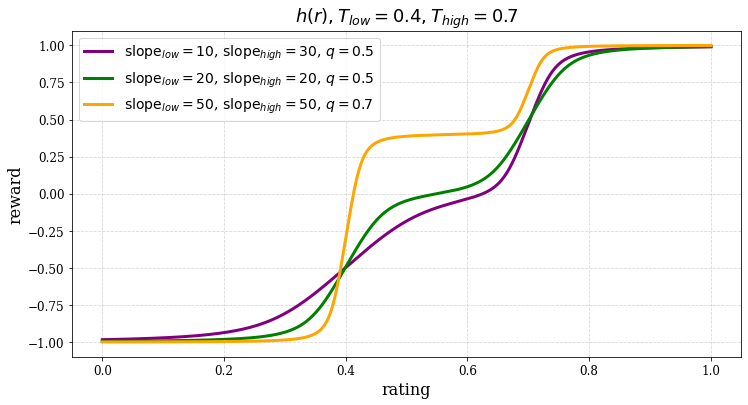

In [73]:
# plotting how the function looks for different contest parameters
def ccp_sigmoid(x, tau):
  return 0.5*np.sqrt(((x/tau + 1) ** 2) + 1) - 0.5*np.sqrt(((x/tau - 1) ** 2) + 1)

def ccp_smooth_f(x, slope_low=50, slope_high=20, T_low=0.4, T_high=0.7, q=0.5):
  return q*ccp_sigmoid(x - T_low, tau=1/slope_low) + (1-q)*ccp_sigmoid(x - T_high, tau=1/slope_high)

fig, ax = plt.subplots(1,1,figsize=(12,6))
r = np.linspace(0, 1, 1000)
ax.plot(r,ccp_smooth_f(r, slope_low=10, slope_high=30),color='purple', label="$\mathrm{slope}_{low}=10$, $\mathrm{slope}_{high}=30$, $q=0.5$")
ax.plot(r,ccp_smooth_f(r, slope_low=20),color='green', label='$\mathrm{slope}_{low}=20$, $\mathrm{slope}_{high}=20$, $q=0.5$')
ax.plot(r,(ccp_smooth_f(r, slope_low=50, slope_high=50, q=0.7)),color='orange', label='$\mathrm{slope}_{low}=50$, $\mathrm{slope}_{high}=50$, $q=0.7$')
ax.set_xlabel('rating')
ax.set_ylabel('reward')
ax.set_title('$h(r),\t T_{low}=0.4, \t T_{high}=0.7$')
ax.legend()
ax.grid(True)

# Function Definitions

In this section we implement the score function, as well as a differientiable sigmoid-like function used in the definition of $h$:

$$\sigma_\tau^*(z) = 0.5 \cdot \sqrt{(\tau^{-1}(z-T_{low})+1)^2+1} - 0.5 \cdot \sqrt{(\tau^{-1}(z-T_{high})-1)^2+1}$$

We denote $0.5 \cdot \sqrt{(\tau^{-1}(z-T_{low})+1)^2+1}$ with $f(z)$ and $0.5 \cdot \sqrt{(\tau^{-1}(z-T_{high})-1)^2+1}$ with $g(z)$.

Note that both $f(z)$ and $g(z)$ are convex. The maximization target in the response function $\Delta_h(\cdot)$ is a sum of two such sigmoids minus the cost function.

For a convex cost function the target can be expressed as a difference of convex functions. This property allows us to use the CCP method for the optimization. This is an algorithm that uses local 1st order Taylor approximation at each optimization step for the convex part which makes it affine. This provides a local concave approximation of the target function which allows use of solvers for the maximization.

For further reading on CCP refer to *T. Lipp, S. Boyd: "Variations and extension of the convex-concave procedure", 2015*

The functions below are definitions of the functions that compose the target required for the optimization. They are implemented with CVXPY which is the solver we use.


In [3]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope, T):
    return 0.5*cp.norm(cp.hstack([1, (slope*(score(x, w, b)-T) + 1)]), 2)
    # return 0.5*cp.sqrt(1+cp.square((slope*(score(x, w, b) - T) + 1)))

def g(x, w, b, slope, T):
    res = 0.5*cp.norm(cp.hstack([1, (slope*(score(x, w, b) - T) - 1)]), 2)
    return res

def c(x, r, x_dim, scale):
    return (scale)*cp.sum_squares(x-r)

def f_derivative(x, w, b, slope, T):
    return 0.5*cp.multiply(slope*((slope*(score(x, w, b)-T) + 1)/cp.sqrt((slope*(score(x, w, b)-T) + 1)**2 + 1)), w)

def f_batch(x, w, b, slope, T):
    return cp.norm(cp.vstack([np.ones(x.shape[0]), slope*(score(x, w, b) - T) + 1]), 2, axis=0)

def g_batch(x, w, b, slope, T):
    return cp.norm(cp.vstack([np.ones((1, x.shape[0])), cp.reshape((slope*(score(x, w, b)-T) - 1), (1, x.shape[0]))]), 2, axis=0)

def c_batch(x, r, x_dim, scale):
    return (scale)*cp.square(cp.norm(x-r, 2, axis=1))

def f_derivative_batch(x, w, b, slope, T):
    nablas = 0.5*slope*((slope*(score(x, w, b) - T) + 1)/cp.sqrt((slope*(score(x, w, b) - T) + 1)**2 + 1))
    return cp.reshape(nablas, (nablas.shape[0], 1))@cp.reshape(w, (1, x.shape[1]))

# ------------------------------------- Our added functions -------------------------------------
# summing 2 sigmoids to model initial acceptance and higher acceptance in order to model user behavior of wanting to have some margin from min requirements

def f_tot(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * f(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * f(x, w, b, slope_high, Thresh_high)

def g_tot(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * g(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * g(x, w, b, slope_high, Thresh_high)

def f_tot_derivative(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    f_der = cp.pos(acp_reward) * f_derivative(x, w, b, slope_low, Thresh_low) + cp.pos(1-acp_reward) * f_derivative(x, w, b, slope_high, Thresh_high)
    return f_der

def f_tot_batch(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * f_batch(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * f_batch(x, w, b, slope_high, Thresh_high)

def g_tot_batch(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * g_batch(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * g_batch(x, w, b, slope_high, Thresh_high)

def f_tot_derivative_batch(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    return acp_reward * f_derivative_batch(x, w, b, slope_low, Thresh_low)+ (1-acp_reward) * f_derivative_batch(x, w, b, slope_high, Thresh_high)

# -----------------------------------------------------------------------------------------------

# CCP

Defining a CCP class based on the one implemented in the paper referenced above.

Convex-Concave Procedure (in short CCP) is an iterative method for solving optimization problems that are expressed as a difference of convex functions, like the one we have in our problem.

It does so by iterating through a sequence of concave-relaxed problems (using Taylor series to linearize on of the functions), a process that guarantees convergence to local maxima.

As shown in the previous section the response function $\Delta_h$ is a maximization over a difference of convex functions.

In [4]:
class CCP_rank:
    def __init__(self, x_dim, batch_size, funcs, scale):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        self.batch_size = batch_size

        self.x = cp.Variable((batch_size, x_dim))
        self.xt = cp.Parameter((batch_size, x_dim))
        self.r = cp.Parameter((batch_size, x_dim))
        
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1) # bias parameter

        # -------------------- adding our function's params --------------------
        self.slope_low = cp.Parameter(1) # scale of the low threshold sigmoid
        self.slope_high = cp.Parameter(1) # scale of the high threshold sigmoid
        self.T_low = cp.Parameter(1) # low threshold of the sigmoid
        self.T_high = cp.Parameter(1) # high threshold of the sigmoid
        self.acp_reward = cp.Parameter(1) # defines the reward for passing initial threshhold - q in the equations 
        # ----------------------------------------------------------------------

        # -------------------- defining our target function --------------------
        target = cp.diag(self.x@(self.f_derivative(self.xt, self.w, self.b, 
                        self.slope_low, self.slope_high, self.T_low, self.T_high, self.acp_reward).T)) - self.g(self.x, self.w,
                        self.b, self.slope_low, self.slope_high, self.T_low, self.T_high, self.acp_reward) - self.c(self.x, self.r,
                        x_dim, scale)
        # # ----------------------------------------------------------------------
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        # define the problem's objective
        self.prob = cp.Problem(cp.Maximize(cp.sum(target)), constraints)

    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.001 and cnt < 100:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)/self.batch_size
        return self.x.value

    def optimize_X(self, X, w, b, slope_low, slope_high, T_low, T_high, acp_reward):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        T_low = T_low.detach().numpy()
        T_high = T_high.detach().numpy()
        

        # converting our params into numpy arrays with 1 value
        slope_low = np.full(1, slope_low)
        slope_high = np.full(1, slope_high)
        T_low = np.full(1, T_low)
        T_high = np.full(1, T_high)
        acp_reward = np.full(1, acp_reward)

        X = X.numpy()

        self.w.value = w
        self.b.value = b
        self.slope_low.value = slope_low
        self.slope_high.value = slope_high
        self.T_low.value = T_low
        self.T_high.value = T_high
        self.acp_reward.value = acp_reward

        # for non-batch usage
        # return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

        # for batch usage
        return torch.from_numpy(self.ccp(X))

### Delta 
This module implements a convex optimization layer that returns the strategically updated features of the user based on the response function $\Delta_h(\cdot)$. The use of the convex optimization layer allows differentiation of the update with respect to the model parameters. This includes the strategic behavior in the model optimization. 

In [5]:
class DELTA():

    def __init__(self, x_dim, funcs, scale, slope_low, slope_high, acp_reward):
        self.g = funcs["g"]
        self.c = funcs["c"]

        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        # -------------------- adding our function's params --------------------
        self.slope_low = slope_low # scale of the low threshold sigmoid
        self.slope_high = slope_high # scale of the high threshold sigmoid
        self.T_low = cp.Parameter(1) # low threshold of the sigmoid
        self.T_high = cp.Parameter(1) # high threshold of the sigmoid
        self.acp_reward = acp_reward # the relation between the 2 slopes - defines the reward for passing initial threshhold
        # ----------------------------------------------------------------------

        # -------------------- defining our target function --------------------
        target = self.x@self.f_der-self.g(self.x, self.w, self.b, 
                        self.slope_low, self.slope_high, self.T_low, 
                        self.T_high, self.acp_reward)-self.c(self.x, self.r, x_dim, scale)
        # ----------------------------------------------------------------------
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der, self.T_low, self.T_high], variables=[self.x])
        

    def optimize_X(self, X, w, b, F_DER, T_low, T_high):
        return self.layer(X, w, b, F_DER, T_low, T_high)[0]

## Model

The model is a simple single linear layer without activation. To model the strategic behavior a convex optimization layer representing $\Delta_h$ is added before the linear layer.

We allow training with batches, where each batch is a full set of users in a given environment (all competitors) and different batches are simply different competitions. This allows to learn in competitions with a small amount of users without underfitting because of lack of data.  
  

In [74]:
# defining special Dataset for batch handling
class CustomDataset(TensorDataset):
    def __init__(self, X, R):
        """
        Args:
            X (torch.Tensor): The input tensor of shape (m, n, d)
            R (torch.Tensor): The label tensor of shape (m, n)
        """
        self.X = X
        self.R = R

    def __len__(self):
        # Return the number of samples (m)
        return self.X.shape[0]

    # note: need to apply the squeeze function in order to remove the extra dimention
    def __getitem__(self, idx):
        # Return a single sample of shape (n, d)
        return self.X[idx], self.R[idx]

In [6]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, batch_size, env, strategic=False):
        torch.manual_seed(SEED)
        np.random.seed(SEED)

        super(MyStrategicModel, self).__init__()
        self.env = env
        self.x_dim = env.n_features
        self.batch_size = batch_size
        # not sure why test slopes are different from test and train - still done here because original SCMP did it 
        self.train_slope_low, self.train_slope_high, self.test_slope_low, self.test_slope_high = env.slope_low, env.slope_high, 5*env.slope_low, 5*env.slope_high
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/self.x_dim)*(1-2*torch.rand(self.x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(math.sqrt(1/self.x_dim)*(1-2*torch.rand(1, dtype=torch.float64, requires_grad=True)))
        self.acp_reward = env.acp_reward
        self.strategic = strategic
        self.ccp = CCP_rank(self.x_dim, batch_size, env.funcs_batch, env.scale)
        self.delta = DELTA(self.x_dim, env.funcs, env.scale, self.train_slope_low, self.train_slope_high, self.acp_reward)
        self.ccp_time = 0
        self.total_time = 0
        
        
    def forward(self, X, use_delta=False, evaluation=False):
        
        # if self.strategic:
        #     t1 = time.time()
        #     # currently not distinguishing between train and test slopes
        #     Xt, X_opt = self.env.full_dynamic_update(X, self.w, self.b, use_delta)
        #     
        #     self.ccp_time += time.time()-t1
        #     X_opt = Xt if evaluation else X_opt
        #     X_opt = Xt if self.strategic else X_opt
        #     output = self.score(X_opt)
        # else:
        #     output = self.score(X)
        #    
        if not self.strategic:
            X = X.detach()
        t1 = time.time()
        # currently not distinguishing between train and test slopes
        Xt, X_opt = self.env.full_dynamic_update(X, self.w, self.b, use_delta)
        
        self.ccp_time += time.time()-t1
        X_opt = Xt if evaluation else X_opt
        X_opt = Xt if self.strategic else X_opt
        output = self.score(X_opt)
        
        return output


    def normalize_weights(self):
        with torch.no_grad():
            norm = torch.sqrt(torch.sum(self.w**2) + self.b**2)
            self.w /= norm
            self.b /= norm
            
    
    def get_wb(self):
        return self.w, self.b
    
    
    def score(self, x):
        return x@self.w + self.b

    def get_f_ders(self, XT, slope):
        nablas = 0.5*slope*((slope*self.score(XT) + 1)/torch.sqrt((slope*self.score(XT) + 1)**2 + 1))
        return torch.reshape(nablas, (len(nablas), 1))@torch.reshape(self.w, (1, len(self.w)))

    def calc_accuracy(self, R, R_pred):
        # calculating acceptance label from ratings
        Y = self.rating_to_accept(R)
        Y_pred = self.rating_to_accept(R_pred)

        # calculating accuracy based on Y and Y_pred
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./len(Y)
        return acc
    
    def calc_burden(self, X_0, Y):
        # calculating the burden in a similar fashion to the original paper
        X_t, _ = self.env.full_dynamic_update(X_0, self.w, self.b, use_delta=False)
        # i.e., only taking those who were supposed to get accepted
        X_0_pos = X_0[Y==1]
        X_t_pos = X_t[Y==1]
        if len(X_0_pos) == 0:
            return 0
        # and measure how much they moved (although they are supposed to get accepted without effort) in order to get accepted
        return torch.mean(torch.sum((X_0_pos-X_t_pos)**2, dim=1)).detach().numpy()

    
    # convert rating vector to acceptance
    def rating_to_accept(self, R):
        # calculating Y_pred out of score_pred
        Y = np.zeros_like(R)
        # getting the top-k values
        top_k_ranking_indices = np.argsort(R)[-self.env.k:]
        Y[top_k_ranking_indices] = 1
        return Y

    # we use mean squared loss between provided ratings
    def loss(self, Y, Y_pred):
        return torch.mean((Y-Y_pred) ** 2)

    def save_model(self, train_errors, val_errors, train_losses, val_losses, info, path, comment=None):
        if comment is not None:
            path += "/" + comment

        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)

        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')

        with open(path + "/info.txt", "w") as f:
            f.write(info)

    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()

    # we fit according to score as a proxy to the ranking for simplicity reasons
    def fit(self, path, X, R, Xval, Rval, opt, opt_kwargs={"lr":1e-3}, epochs=100, use_delta=False, verbose=False, callback=None, comment=None):
        # labels are the true rating 
        # loading the datasets
        # using our dataset which inherits from TensorDataset
        train_dset = CustomDataset(X, R)
        train_loader = DataLoader(train_dset, batch_size=1, shuffle=True)
        test_dset = CustomDataset(Xval, Rval)
        test_loader = DataLoader(test_dset, batch_size=1, shuffle=True)

        # optimizing the NN
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []

        # adding our score metrics (ndcg, precision, recall...)
        our_train_metrics = []
        our_test_metrics = []

        # defining stopping conditions
        # best_val_error = 1
        best_val_loss = np.inf
        consecutive_no_improvement = 0

        # runnning epochs
        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, Rbatch in train_loader:
#                 try:
                # need to squeeze in order to remove redundant dimention
                Xbatch = Xbatch.squeeze()
                Rbatch = Rbatch.squeeze()

                opt.zero_grad()
                Rbatch_pred = self.forward(Xbatch, use_delta=use_delta)
                l = self.loss(Rbatch, Rbatch_pred)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                with torch.no_grad():
                    # calculating accuracy
                    e = self.calc_accuracy(Rbatch, Rbatch_pred)

                    # calculating different scores to the ranking
                    Y = self.rating_to_accept(Rbatch)
                    Y_pred = self.rating_to_accept(Rbatch_pred)
                    our_train_metrics.append({
                        "epoch num" : epoch,
                        "batch num" : batch,
                        "accuracy" : e,
                        "loss" : l.item(),
                        "ndcg" : ndcg_score(np.expand_dims(Rbatch, 0), np.expand_dims(Rbatch_pred, 0)),
                        "precision" : precision_score(Y, Y_pred),
                        "recall" : recall_score(Y, Y_pred),
                        "burden" : self.calc_burden(Xbatch, Y),
                    })
                    
                    train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | err: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
                batch += 1
                if callback is not None:
                    callback()
#                 except:
#                     print("failed")

            with torch.no_grad():
                total_loss = 0
                total_error = 0
                batch = 0
                for Xbatch, Rbatch in test_loader:
#                     try:
                    Xbatch = Xbatch.squeeze()
                    Rbatch = Rbatch.squeeze()
                    Rval_pred = self.forward(Xbatch, evaluation=True, use_delta=False)
                    val_loss = self.loss(Rbatch, Rval_pred).item()
                    total_loss += val_loss
                    val_error = 1-self.calc_accuracy(Rbatch, Rval_pred)
                    total_error += val_error
                    batch += 1
#                     except:
#                         print("failed")
                avg_loss = total_loss/batch
                avg_error = total_error/batch
                # calculating different scores to the ranking
                Y = self.rating_to_accept(Rbatch)
                Y_pred = self.rating_to_accept(Rval_pred)
                our_test_metrics.append({
                    "epoch num" : epoch,
                    "batch num" : batch,
                    "accuracy" : 1 - avg_error,
                    "loss" : avg_loss,
                    "ndcg" : ndcg_score(np.expand_dims(Rbatch, 0), np.expand_dims(Rval_pred, 0)),
                    "precision" : precision_score(Y, Y_pred),
                    "recall" : recall_score(Y, Y_pred),
                    "burden" : self.calc_burden(Xbatch, Y),
                })
                val_losses.append(avg_loss)
                val_errors.append(avg_error)
                if avg_loss < best_val_loss:
                        consecutive_no_improvement = 0
                        best_val_error = avg_error
                        info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\nslope low: {}\nslope high: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\n".format(
                        time.time()-total_time, epoch, self.batch_size, self.train_slope_low, self.train_slope_high, opt_kwargs["lr"], avg_loss, avg_error)
                        self.save_model(train_errors, val_errors, train_losses, val_losses, info, path, comment)
                        print("model saved!")

                else:
                    consecutive_no_improvement += 1
                    if consecutive_no_improvement >= 4:
                        break

            t2 = time.time()
            if verbose:
                print("------------- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))

        self.total_time = time.time()-total_time
        print("training time: {} seconds".format(self.total_time))
        # returning our metrics in addition to the errors
        return our_train_metrics, our_test_metrics
    
    

### Data Generation
We generate data in the following procedure:
- user features generated randomly
- ground truth rating model is $r(x)=u^Tx$ 
- observed noisy ratings $\tilde{r}(x)=r(x)+\epsilon$, where $\epsilon \sim \mathcal{N}(0,\sigma^2_\epsilon)$.

## Training Environment

Each training step will include several dynamic iterations (user feature updates) and after that a single update of the system features $\theta$.

Pseudocode of the training:

- until model convergence:
    - for $t = 0:T$
        - Get $T_{low},T_{high}$ from $r_{\theta}(\cdot)$ and $x_t$
        - $x_{t+1} = \Delta_h(x_t,T_{low},T_{high})$
    - Update model based on $x_T,r$
    - $w,b \leftarrow \text{gradient update from rating MSE loss}$

In test time we will evaluate features after the dynamic iteration i.e., $x_T$.

In [63]:
class RankingEnv():
    """
    Strategic Classification Environment
    """
    def __init__(self, rating_noise, feature_noise, n_features, k, k_tag, n_users, slope_low, slope_high, acp_reward, funcs, funcs_batch, scale, T_max=5, n_batch=1):
        self.rating_noise = rating_noise
        self.feature_noise = feature_noise
        self.n_features = n_features
        self.k = k  # k is number of accepted users
        self.k_tag = k_tag  # k' < k sets the threshold of confidant acceptance
        self.system_attributes = torch.randn(size=(n_features,), requires_grad=False)*0.1  # u system rating vector, multiplying in 0.1, the scale
        self.system_attributes = self.system_attributes / torch.norm(self.system_attributes)
        
        # system variables 
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/n_features)*(1-2*torch.rand(n_features, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(math.sqrt(1/n_features)*(1-2*torch.rand(1, dtype=torch.float64, requires_grad=True)))
        
        # Delta parameters
        self.slope_low = slope_low # scale of the low threshold sigmoid
        self.slope_high = slope_high # scale of the high threshold sigmoid
        self.acp_reward = acp_reward # the relation between the 2 slopes - defines the reward for passing initial threshhold
        self.scale = scale  # cost function scale
        self.n_batch = n_batch # number of train-set batches. diffault is 1 (without batches - 1 for train and 1 for test)
        self.funcs = funcs
        self.funcs_batch = funcs_batch
        self.ccp = CCP_rank(n_features, batch_size=n_users, funcs=funcs_batch, scale=scale)
        self.delta = DELTA(n_features, funcs, scale, slope_low, slope_high, acp_reward)

        
        # user variables 
        self.n_users = n_users
        self.t = 0  # time indicator
        self.T_max = T_max  #  number of dynamic iterations
    
    
    # generating dataset for train or test sets. In case of a train-set, generate n_batch datasets. In case of test-set, generate 1 dataset.
    def generate_dataset(self, is_test=False, uniform_dist=False):
        dataset_num = self.n_batch if not is_test else 1
        X = torch.zeros((dataset_num,self.n_users, self.n_features))
        R = torch.zeros((dataset_num,self.n_users))
        y = torch.zeros((dataset_num,self.n_users))

        for i in range(dataset_num):
            X[i,:,:] = self.generate_users(self.n_users, uniform_dist=uniform_dist)
            R[i,:] = self.rating(X[i,:,:])
            y[i,:] = self.get_true_accepted(X[i,:,:]) 
        # add noise to the features 
        X_noisy = X + torch.randn_like(X) * self.feature_noise
        return X_noisy,R,y
        
    def generate_users(self, n_users, uniform_dist=False):
        if uniform_dist:
            return torch.rand(size = (n_users, self.n_features)) * 4 - 2 # random numbers from a uniform distribution [0.1, 0.1]^n_features
        # if not uniform distribution then use normal 
        else:
            return torch.randn(size = (n_users, self.n_features)) * 1  # multiplying by 1, the scale
    
    
    def rating(self, users):
        # return noisy users rating, when the noise is normally distributed
        clean_ratings = users@self.system_attributes.T
        noise = torch.randn_like(clean_ratings) * self.rating_noise # multiplying in the noisyscale
        return clean_ratings + noise
    
    def set_slope(self, slope_low, slope_high):
        self.slope_low = slope_low
        self.slope_high = slope_high
        self.ccp = CCP_rank(self.n_features, batch_size=self.n_users, funcs=self.funcs_batch, scale=self.scale)
        self.delta = DELTA(self.n_features, self.funcs, self.scale, self.slope_low, self.slope_high, self.acp_reward)
        
    def set_scale(self, scale):
        self.scale = scale
        self.ccp = CCP_rank(self.n_features, batch_size=self.n_users, funcs=self.funcs_batch, scale=scale)
        self.delta = DELTA(self.n_features, self.funcs, scale, self.slope_low, self.slope_high, self.acp_reward)
        
    def get_thresh(self, X):
        ranking = self.score(X)
        # reversing the sort into a descending order
        sorted_ranking , _= torch.sort(ranking, descending=True)
        # calculate thresholds from k and k_tag
        return sorted_ranking[self.k-1].reshape(1), sorted_ranking[self.k_tag-1].reshape(1)
    
    # returns ground truth ratings for users
    def get_true_accepted(self, X):
        ranking = self.rating(X)
        acceptance = torch.zeros_like(ranking)
        # sort ranking in descending order
        _ , sorted_indices = torch.sort(ranking, descending=True)
        acceptance[sorted_indices[:self.k]] = 1
        return acceptance
    
    def user_features_update(self, X, Xt, use_delta=False):
        # update features based on the response function
        self.t += 1
        # update features
        T_low, T_high = self.get_thresh(Xt)
        XT = self.ccp.optimize_X(X, self.w, self.b, self.slope_low, self.slope_high, T_low,
                                 T_high, self.acp_reward)
        if use_delta:
            F_DER = self.get_f_ders(XT, self.slope_low, self.slope_high, T_low, T_high)
            X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER, T_low, T_high) # Xopt should be equal to XT but repeat for gradients
            return X_opt # this includes the whole dynamic process in the derivatives
        else:
            return XT 
        
    def update_wb(self, w, b):
        self.w = w
        self.b = b
        self.t = 0  # reset time as new paramemters show 
    
    def full_dynamic_update(self, X, w, b, use_delta=False):
        self.update_wb(w, b)
        Xt = X
        for _ in range(self.T_max):
            Xt = self.user_features_update(X, Xt, use_delta=use_delta)
        # if delta wasn't used it must be used in the last step
        X_opt = Xt
        # if not use_delta:
        #     T_low, T_high = self.get_thresh(Xt)
        #     F_DER = self.get_f_ders(Xt, self.slope_low, self.slope_high, T_low, T_high)
        #     X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER, T_low, T_high)
        # returning both in order to support evaluation condition in forward
        return Xt, X_opt
    
    
    def get_f_ders_helper(self, XT, slope, T):
        nablas = 0.5*slope*((slope*(self.score(XT) - T) + 1)/torch.sqrt((slope*(self.score(XT) - T) + 1)**2 + 1))
        return torch.reshape(nablas, (len(nablas), 1))@torch.reshape(self.w, (1, len(self.w)))
    
    def get_f_ders(self, XT, slope_low, slope_high, T_low, T_high):
        return (self.acp_reward*self.get_f_ders_helper(XT, slope_low, T_low) + 
                (1-self.acp_reward)*self.get_f_ders_helper(XT, slope_high, T_high))
    
    def score(self, x):
        return x@self.w + self.b
    

Initializing our environment:

In [8]:
# initialize env
funcs = {"f": f_tot, "g": g_tot, "f_derivative": f_tot_derivative, "c": c, "score": score}
funcs_batch = {"f": f_tot_batch, "g": g_tot_batch, "f_derivative": f_tot_derivative_batch, "c": c_batch, "score": score}
env_params = {'noisyscale' : 0.01,
              'n_features' : 5,
              'k' : 40,
              'k_tag' : 20,
              'n_users': 400,
              'slope_low' : 40,
              'slope_high' : 10,
              'acp_reward' : 0.6,
              'funcs' : funcs,
              'funcs_batch' : funcs_batch,
              'scale' : 1}

rank_env = RankingEnv(**env_params)

# TODO: integrate eval_slope_low and eval_slope_high into the model

Generating train and test sets:

In [11]:
# generate train and test sets
X_train, R_train, y_train = rank_env.generate_dataset()
X_test, R_test, y_test = rank_env.generate_dataset()

c:\Users\Ori Anvar\anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3281.)


## Further Questions (When finished delete)
1. Goals:
    - Develop a system capable of coping with contest behavior🦚
    - Deploy system on toy example with synthetic data🦚
    - Adding batch option in order to train well on small datasets (instead of training on a subset of users from 1 experiment, do multiple experiments on small amounts of users)🦚
    - Adding Naive non-strategic model as a baseline to see how it copes with strategic data. run 2D and generate plots for comparison
    - Change contest parameters and study effect on precision and burden (slopes, k, k', acp_rate)


# Experiments
In this section we will perform different experiments in order to test our model's performance, testing different trade-offs (such as the accuracy-burden trade-off) and exploring the different contest parameters and their effects on the results. 

### Helper functions

Helper function for plotting the results.

In [9]:
# plotting the user's behavior function (h)
def view_reward_func(rank_env, R, X):
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    r = np.linspace(R.min(), R.max(), 100)
    T_low, T_high = rank_env.get_thresh(X[0,:,:])
    T_low = T_low.detach().numpy()
    T_high = T_high.detach().numpy()
    slope_low = rank_env.slope_low
    slope_high = rank_env.slope_high
    q = rank_env.acp_reward
    ax.plot(r,ccp_smooth_f(r, slope_low=slope_low, slope_high=slope_high, T_low=T_low, T_high=T_high, q=q),color='purple')
    ax.set_xlabel('rating')
    ax.set_ylabel('reward')
    ax.set_title('$h(r)$')
    ax.grid(True)

In [59]:
def plot_rating_change(rank_env, model, X, title='Test Set'):
    X = X.squeeze()
    w, b = model.get_wb()
    R_final = model.forward(X).detach().numpy()
    R_init = model.score(X).detach().numpy()
    y_pred = model.rating_to_accept(R_final)
    point_size = 15
    # plot function
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    r = np.linspace(R_final.min(), R_final.max(), 100)
    T_low, T_high = rank_env.get_thresh(X)
    T_low = T_low.detach().numpy()
    T_high = T_high.detach().numpy()
    slope_low = rank_env.slope_low
    slope_high = rank_env.slope_high
    q = rank_env.acp_reward
    ax.plot(r, ccp_smooth_f(r, slope_low=slope_low, slope_high=slope_high, T_low=T_low, T_high=T_high, q=q),color='purple', label='reward function', alpha=0.5)
    
    # plotting scatter plots of test set
    reward_init = ccp_smooth_f(R_init, slope_low=slope_low, slope_high=slope_high, T_low=T_low, T_high=T_high, q=q)
    reward_final = ccp_smooth_f(R_final, slope_low=slope_low, slope_high=slope_high, T_low=T_low, T_high=T_high, q=q)
    ax.scatter(R_init, reward_init, marker='o', s=point_size, color='b', label='Initial Ratings')
    ax.scatter(R_final[y_pred == 1], reward_final[y_pred == 1], marker='o', s=point_size, color='g', label='Final Features - Accepted')
    ax.scatter(R_final[y_pred == 0], reward_final[y_pred == 0], marker='o', s=point_size, color='r', label='Final Features - Rejected')
    # Calculate the differences
    U = R_final - R_init
    V = reward_final - reward_init
    # ax.quiver(R_init, reward_init, U, V, angles='xy', scale_units='xy', scale=1, color='gray')
    
    ax.set_xlabel('rating')
    ax.set_ylabel('reward')
    ax.set_title(f'$h(r)$, {title}')
    ax.grid(True)
    ax.legend()

In [10]:
# plotting the model's Boundary Line
def get_perp_line(w, b, rank_env, X_T):
    x1 = np.linspace(-3, 3, 100)
    w0 = w[0].detach().numpy()
    w1 = w[1].detach().numpy()
    # normalize w for better visualization
    w_norm = np.sqrt(w0 ** 2 + w1 ** 2)
    w0 = w0 / w_norm
    w1 = w1 / w_norm
    b_d = b.detach().numpy()
    T_low, _ = rank_env.get_thresh(X_T)
    x2 = (-w0*x1 + T_low.detach().numpy() - b_d)/w1
    return x1, x2


In [40]:
# A function for plotting users before and after delta for the test set
def our_scatter(rank_env, model, X, test_metrics, title='Test Set'):
    X = X.squeeze()
    w, b = model.get_wb()
    X_T, _ = rank_env.full_dynamic_update(X, w, b)
    R_pred = model.forward(X)
    y_pred = model.rating_to_accept(R_pred.detach().numpy())
    point_size = 30
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # plotting scatter plots of test set
    ax.scatter(X[:, 0], X[:, 1], marker='o', s=point_size, color='b', label='Initial Features')
    ax.scatter(X_T[y_pred == 1, 0], X_T[y_pred == 1, 1], marker='o', s=point_size, color='g', label='Final Features - Accepted')
    ax.scatter(X_T[y_pred == 0, 0], X_T[y_pred == 0, 1], marker='o', s=point_size, color='r', label='Final Features - Rejected')
    # Calculate the differences
    U = X_T[:, 0] - X[:, 0]
    V = X_T[:, 1] - X[:, 1]
    ax.quiver(X[:, 0].mean(), X[:, 1].mean(), 2*U.mean(), 2*V.mean(), angles='xy', scale_units='xy', scale=0.2, color='k', label='Average Direction')
    ax.quiver(X[:, 0], X[:, 1], U, V, angles='xy', scale_units='xy', scale=1, color='gray')
    # adding threshold lines
    x1, x2 = get_perp_line(w, b, rank_env, X_T)
    ax.plot(x1, x2, linestyle='dashed', label='model decision')
    x1, x2 = get_perp_line(rank_env.system_attributes, torch.Tensor([0]), rank_env, X_T)
    ax.plot(x1, x2, linestyle='dashed', label='ground truth decision')
    ax.legend()
    ax.set_xlabel('feature 1')
    ax.set_ylabel('feature 2')
    ax.set_xlim([-2.5, 2.5])
    ax.set_ylim([-2.5, 2.5])
    precision = test_metrics[test_metrics['epoch num'] == 9]['precision'].values[0]
    recall = test_metrics[test_metrics['epoch num'] == 9]['recall'].values[0]
    accuracy = test_metrics[test_metrics['epoch num'] == 9]['accuracy'].values[0]
    ax.set_title(f'{title}, Precision = {precision:.3f}, Recall = {recall:.3f}, Accuracy = {accuracy:.3f}')

### Baseline
In this experiment we will run 2 models, one non-strategic and the other strategic, with strategic data (i.e. users which change their features in order to achieve better results) and comparing their results.

In [32]:
# define models 
model_classic = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
model_strategic = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)

path_strategic = "./tests/baseline/strategic"
path_classical = "./tests/baseline/classical"
epochs = 10
batch_size = env_params['n_users']
total = []
ccp = []

print('now training classical model')
classic_train_metrics, classic_test_metrics = model_classic.fit(path_classical, X_train, R_train, X_test, R_test,
                    opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                    epochs=epochs, verbose=True,
                   comment="batched")

print('now training strategic model')
strategic_train_metrics, strategic_test_metrics = model_strategic.fit(path_strategic, X_train, R_train, X_test, R_test,
                    opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                    epochs=epochs, verbose=True,
                   comment="batched")

total_time = model_strategic.total_time
ccp_time = model_strategic.ccp_time
total.append(total_time)
ccp.append(ccp_time)

# saving baseline
pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
pd.DataFrame(classic_train_metrics).to_csv(path_classical + '/train_metrics.csv')
pd.DataFrame(classic_test_metrics).to_csv(path_classical + '/test_metrics.csv')
pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')

now training classical model
batch 001 / 001 | loss: 1.80524 | err: 0.36000
model saved!
------------- epoch 001 / 010 | time: 011 sec | loss: 1.04843 | err: 0.26000
batch 001 / 001 | loss: 1.09649 | err: 0.30000
model saved!
------------- epoch 002 / 010 | time: 011 sec | loss: 0.70010 | err: 0.24000
batch 001 / 001 | loss: 0.67586 | err: 0.23000
model saved!
------------- epoch 003 / 010 | time: 012 sec | loss: 0.52855 | err: 0.14000
batch 001 / 001 | loss: 0.48460 | err: 0.16000
model saved!
------------- epoch 004 / 010 | time: 012 sec | loss: 0.47055 | err: 0.12000
batch 001 / 001 | loss: 0.43898 | err: 0.12000
model saved!
------------- epoch 005 / 010 | time: 013 sec | loss: 0.58159 | err: 0.09000
batch 001 / 001 | loss: 0.51107 | err: 0.11000
model saved!
------------- epoch 006 / 010 | time: 014 sec | loss: 0.62786 | err: 0.09000
batch 001 / 001 | loss: 0.57625 | err: 0.09000
model saved!
------------- epoch 007 / 010 | time: 010 sec | loss: 0.57995 | err: 0.09000
batch 001 / 

### 2D Experiments

Running simple experiments in 2D (meaning each user will have 2 features) to understand the user behavior better.

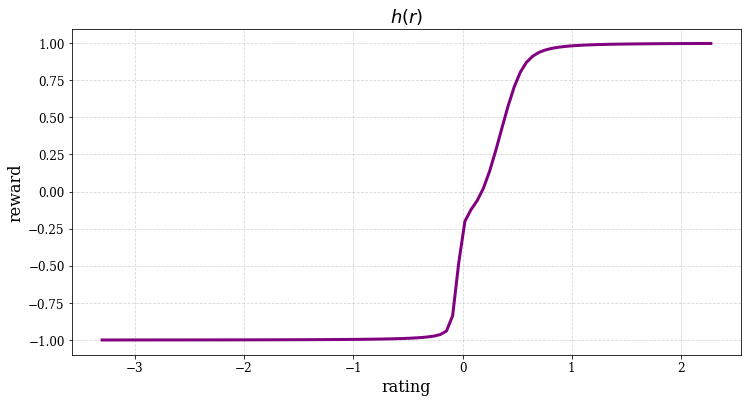

In [14]:
slope_val = 1
n_features = 2
scale = 5

# training with different slopes
env_params = {'rating_noise' : 0,
            'feature_noise' : 0.1,
            'n_features' : n_features,
            'k' : 30,
            'k_tag' : 10,
            'n_users': 100,
            'slope_low' : slope_val,
            'slope_high' : slope_val,
            'acp_reward' : 0.4,
            'funcs' : funcs,
            'funcs_batch' : funcs_batch,
            'scale' : scale,
            'n_batch' : 5}

rank_env = RankingEnv(**env_params)

# generate train and test sets
X_train, R_train, y_train = rank_env.generate_dataset(is_test=False)
X_test, R_test, y_test = rank_env.generate_dataset(is_test=True)

# set slope_val and scale to fit the rating range
rating_range = R_train.max() - R_train.min()
rating_range = rating_range.detach().numpy()
rank_env.set_slope(rating_range*slope_val*4, rating_range*slope_val)
feature_std = X_train.std() ** 2
rank_env.set_scale(scale / (feature_std))

view_reward_func(rank_env, R_test, X_test)

In [15]:

# defining the model
model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)
slope_str = str(slope_val).replace('.', ',')
path_strategic = f"./tests/2d_test/strategic"
epochs = 10
batch_size = env_params['n_users']
total = []
ccp = []

strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                    opt=torch.optim.Adam, opt_kwargs={"lr": (5e-2)},
                    epochs=epochs, verbose=True,
                comment="batched")

# convert to pd DataFrame
strategic_train_metrics = pd.DataFrame(strategic_train_metrics)
strategic_test_metrics = pd.DataFrame(strategic_test_metrics)

c:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 0.67372 | err: 0.00000
batch 002 / 005 | loss: 0.52403 | err: 0.01000
batch 003 / 005 | loss: 0.50828 | err: 0.02667
batch 004 / 005 | loss: 0.48956 | err: 0.02000
batch 005 / 005 | loss: 0.46957 | err: 0.02400
model saved!
------------- epoch 001 / 010 | time: 009 sec | loss: 0.40263 | err: 0.02000
batch 001 / 005 | loss: 0.33899 | err: 0.02000
batch 002 / 005 | loss: 0.32014 | err: 0.05000
batch 003 / 005 | loss: 0.28855 | err: 0.04000
batch 004 / 005 | loss: 0.28297 | err: 0.03500
batch 005 / 005 | loss: 0.27387 | err: 0.03600
model saved!
------------- epoch 002 / 010 | time: 019 sec | loss: 0.21932 | err: 0.02000
batch 001 / 005 | loss: 0.21713 | err: 0.08000
batch 002 / 005 | loss: 0.21451 | err: 0.05000
batch 003 / 005 | loss: 0.20784 | err: 0.04000
batch 004 / 005 | loss: 0.20023 | err: 0.03500
batch 005 / 005 | loss: 0.19333 | err: 0.02800
model saved!
------------- epoch 003 / 010 | time: 010 sec | loss: 0.14127 | err: 0.02000
batch 001 / 005 | loss: 0

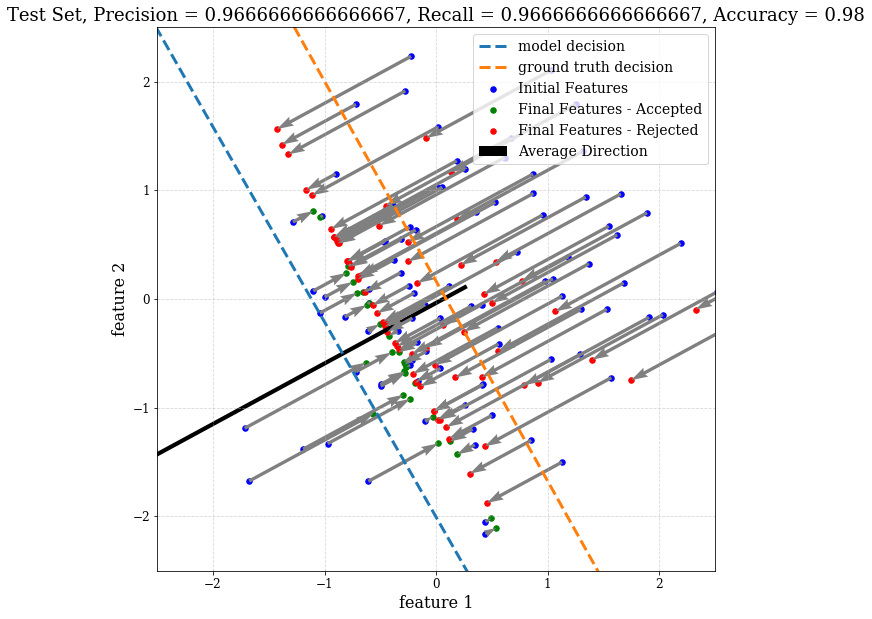

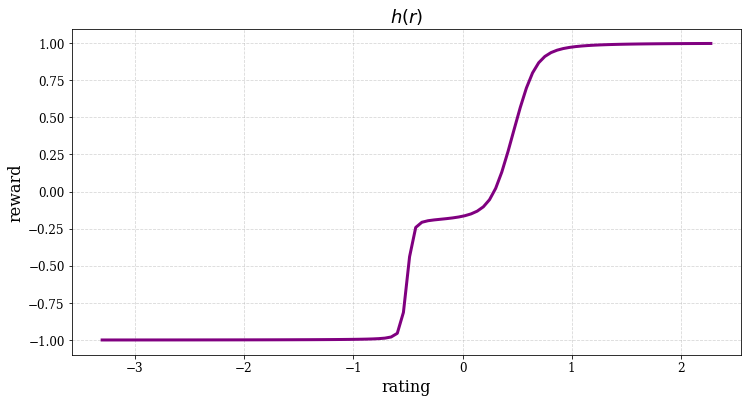

In [18]:
# plotting for the test batch
our_scatter(rank_env, model, X_test, test_metrics=strategic_test_metrics)
view_reward_func(rank_env, R_test, X_test)

We can see thet the users which are not accepted change their features to be close to the acceptance line (as expected), but the strongly accepted users seem to decrease their features for some reason. **We need to test why this happens, maybe the CCP approximation fails**.

### 2D Experiments with uniform distribution of user features

In this experiment we test a different init state where the initial distribution of the user features is uniform instead of normal.

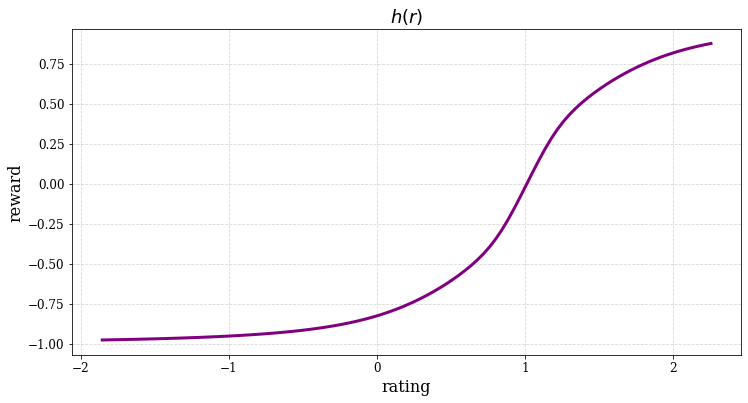

In [67]:
slope_val = 0.3
n_features = 2
scale = 10

# training with different slopes
env_params = {'rating_noise' : 0,
            'feature_noise' : 0.3,
            'n_features' : n_features,
            'k' : 30,
            'k_tag' : 30,
            'n_users': 100,
            'slope_low' : slope_val,
            'slope_high' : slope_val,
            'acp_reward' : 0.3,
            'funcs' : funcs,
            'funcs_batch' : funcs_batch,
            'scale' : scale,
            'n_batch' : 5,
             'T_max': 6}

rank_env = RankingEnv(**env_params)
rank_env_non_strategic = copy.deepcopy(rank_env) 

# generate **uniform** train and test sets
X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)

# set slope_val and scale to fit the rating range
rating_range = R_train.max() - R_train.min()
rating_range = rating_range.detach().numpy()
rank_env.set_slope(rating_range*slope_val*4, rating_range*slope_val)
feature_var= X_train.var()
rank_env.set_scale(scale / (feature_var))

view_reward_func(rank_env, R_test, X_test)


In [68]:
model_non_strategic = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env_non_strategic, strategic=False)
model_strategic = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)

path_strategic = f"./tests/2d_test_uniform/strategic"
path_non_strategic = f"./tests/2d_test_uniform/non_strategic"
epochs = 10
batch_size = env_params['n_users']
total = []
ccp = []

# for non-strategic with strategic data - use_delta must be set to false, else set it to true
# TODO : this can be unified maybe such that use_delta is set according to strategic 
non_strategic_train_metrics, non_strategic_test_metrics = model_non_strategic.fit(path_non_strategic, X_train, R_train, X_test, R_test,
                    opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                    epochs=epochs, use_delta=False, verbose=True,
                comment="batched")
# learning rate is crucial for the success of the model. DO NOT TOUCH!!!!
strategic_train_metrics, strategic_test_metrics = model_strategic.fit(path_strategic, X_train, R_train, X_test, R_test,
                    opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                    epochs=epochs, use_delta=True, verbose=True,
                comment="batched")


# convert to pd DataFrame
strategic_train_metrics = pd.DataFrame(strategic_train_metrics)
strategic_test_metrics = pd.DataFrame(strategic_test_metrics)
non_strategic_train_metrics = pd.DataFrame(non_strategic_train_metrics)
non_strategic_test_metrics = pd.DataFrame(non_strategic_test_metrics)

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 2.06330 | err: 0.60000
batch 002 / 005 | loss: 2.07729 | err: 0.60000
batch 003 / 005 | loss: 1.86657 | err: 0.58000
batch 004 / 005 | loss: 1.76383 | err: 0.53000
batch 005 / 005 | loss: 1.65329 | err: 0.48400
model saved!
------------- epoch 001 / 010 | time: 015 sec | loss: 0.93790 | err: 0.18000
batch 001 / 005 | loss: 0.93767 | err: 0.24000
batch 002 / 005 | loss: 0.86240 | err: 0.25000
batch 003 / 005 | loss: 0.75728 | err: 0.19333
batch 004 / 005 | loss: 0.66235 | err: 0.16500
batch 005 / 005 | loss: 0.58943 | err: 0.15200
model saved!
------------- epoch 002 / 010 | time: 014 sec | loss: 0.21551 | err: 0.10000
batch 001 / 005 | loss: 0.21099 | err: 0.04000
batch 002 / 005 | loss: 0.18723 | err: 0.06000
batch 003 / 005 | loss: 0.15641 | err: 0.06000
batch 004 / 005 | loss: 0.14514 | err: 0.06000
batch 005 / 005 | loss: 0.13467 | err: 0.06000
model saved!
------------- epoch 003 / 010 | time: 007 sec | loss: 0.08890 | err: 0.10000
batch 001 / 005 | loss: 0

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 2.53984 | err: 0.60000
batch 002 / 005 | loss: 2.15375 | err: 0.60000
batch 003 / 005 | loss: 2.04620 | err: 0.59333
batch 004 / 005 | loss: 1.90053 | err: 0.54500
batch 005 / 005 | loss: 1.72306 | err: 0.50400
model saved!
------------- epoch 001 / 010 | time: 043 sec | loss: 0.91907 | err: 0.18000
batch 001 / 005 | loss: 0.78628 | err: 0.22000
batch 002 / 005 | loss: 0.73183 | err: 0.23000
batch 003 / 005 | loss: 0.68981 | err: 0.21333
batch 004 / 005 | loss: 0.61661 | err: 0.17500
batch 005 / 005 | loss: 0.55445 | err: 0.15200
model saved!
------------- epoch 002 / 010 | time: 052 sec | loss: 0.20993 | err: 0.10000
batch 001 / 005 | loss: 0.21472 | err: 0.06000
batch 002 / 005 | loss: 0.18046 | err: 0.07000
batch 003 / 005 | loss: 0.15896 | err: 0.06667
batch 004 / 005 | loss: 0.13774 | err: 0.06500
batch 005 / 005 | loss: 0.12602 | err: 0.06400
model saved!
------------- epoch 003 / 010 | time: 041 sec | loss: 0.08747 | err: 0.10000
batch 001 / 005 | loss: 0

strategic model, w = Parameter containing:
tensor([ 0.8428, -0.1870], requires_grad=True), b = Parameter containing:
tensor([-0.0556], requires_grad=True)
non-strategic model, w = Parameter containing:
tensor([ 0.8533, -0.1954], requires_grad=True), b = Parameter containing:
tensor([-0.0433], requires_grad=True)


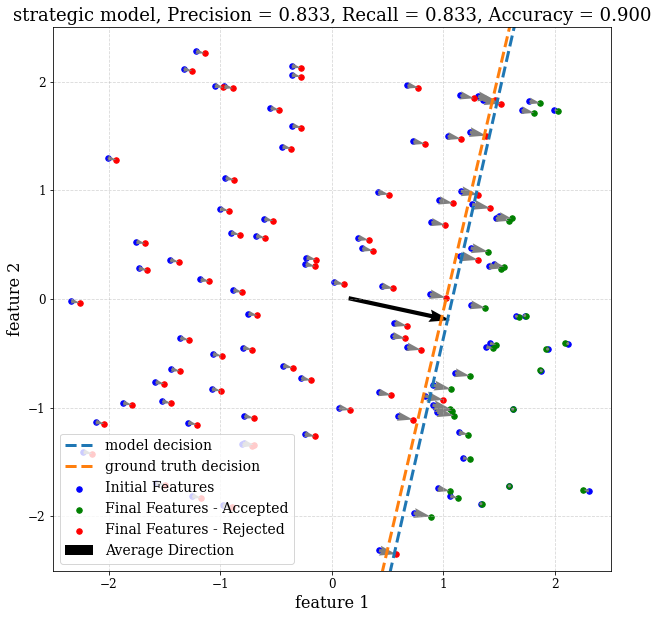

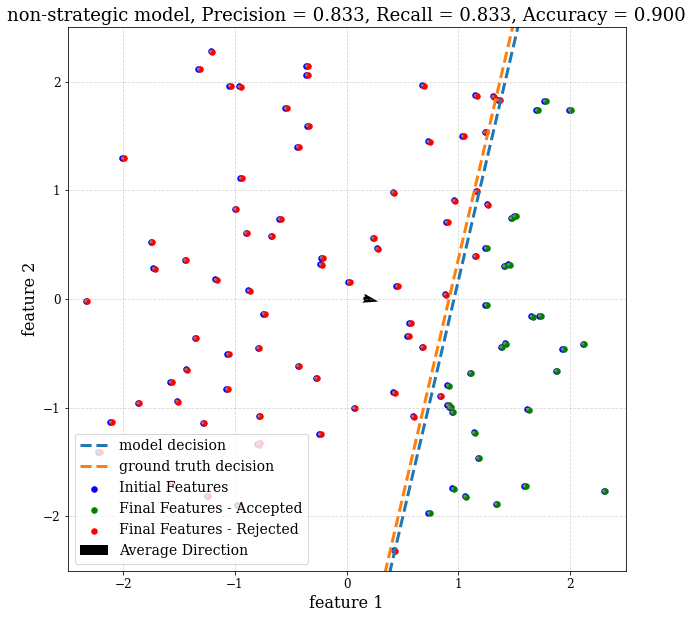

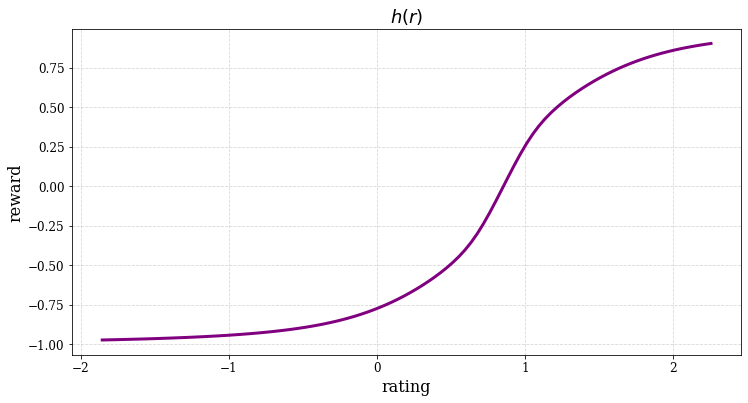

In [71]:
# plotting for the test batch
print(f'strategic model, w = {rank_env.w}, b = {rank_env.b}')
our_scatter(rank_env, model_strategic, X_test, strategic_test_metrics, title='strategic model')
print(f'non-strategic model, w = {rank_env_non_strategic.w}, b = {rank_env_non_strategic.b}')
our_scatter(rank_env_non_strategic, model_non_strategic, X_test, non_strategic_test_metrics, title='non-strategic model')
view_reward_func(rank_env, R_test, X_test)

This is an interesting result (if it is true), it may mean that ranking is less sensitive to strategic behavior. This makes some sense as if everyone increases their rating at the same rate then just accepting the top-$k$ will move the threshold. This is the behavior that we have seen in classic strategic classification. It does not explain why the user barely change their features. 

We should try regularizing for burden or maybe a more complex rating model, such as quadratic.

### Accuracy for different slopes

In those experiment we want to test the model's performance for different slopes.
We will do this in 2 versions, where in each one we will change the number of features per user (and therefore the complexity of the data).

**Part 1:** Where users have only 2 features (in 2D).

now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.66657 | err: 0.40000
batch 002 / 005 | loss: 1.63206 | err: 0.40000
batch 003 / 005 | loss: 1.54856 | err: 0.39667
batch 004 / 005 | loss: 1.39040 | err: 0.37000
batch 005 / 005 | loss: 1.25165 | err: 0.33200
model saved!
------------- epoch 001 / 010 | time: 016 sec | loss: 0.53978 | err: 0.20000
batch 001 / 005 | loss: 0.57031 | err: 0.15000
batch 002 / 005 | loss: 0.51803 | err: 0.15000
batch 003 / 005 | loss: 0.50551 | err: 0.14000
batch 004 / 005 | loss: 0.45120 | err: 0.12750
batch 005 / 005 | loss: 0.40485 | err: 0.11200
model saved!
------------- epoch 002 / 010 | time: 010 sec | loss: 0.14289 | err: 0.08000
batch 001 / 005 | loss: 0.18068 | err: 0.05000
batch 002 / 005 | loss: 0.13601 | err: 0.04500
batch 003 / 005 | loss: 0.10992 | err: 0.04333
batch 004 / 005 | loss: 0.09350 | err: 0.04500
batch 005 / 005 | loss: 0.08243 | err: 0.04000
model saved!
------------- epoch 003 / 010 | time: 009 sec | loss: 0.04571 | err: 0.04000
batch 001 / 005 | loss: 0

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.67219 | err: 0.40000
batch 002 / 005 | loss: 1.63718 | err: 0.40000
batch 003 / 005 | loss: 1.55227 | err: 0.39667
batch 004 / 005 | loss: 1.39357 | err: 0.37000
batch 005 / 005 | loss: 1.25409 | err: 0.33200
model saved!
------------- epoch 001 / 010 | time: 009 sec | loss: 0.53805 | err: 0.19000
batch 001 / 005 | loss: 0.57076 | err: 0.15000
batch 002 / 005 | loss: 0.51785 | err: 0.15000
batch 003 / 005 | loss: 0.50474 | err: 0.14000
batch 004 / 005 | loss: 0.45010 | err: 0.12750
batch 005 / 005 | loss: 0.40417 | err: 0.11200
model saved!
------------- epoch 002 / 010 | time: 010 sec | loss: 0.14531 | err: 0.08000
batch 001 / 005 | loss: 0.18279 | err: 0.05000
batch 002 / 005 | loss: 0.13752 | err: 0.04500
batch 003 / 005 | loss: 0.11190 | err: 0.04333
batch 004 / 005 | loss: 0.09519 | err: 0.04500
batch 005 / 005 | loss: 0.08464 | err: 0.04000
model saved!
------------- epoch 003 / 010 | time: 014 sec | loss: 0.04785 | err: 0.04000
batch 001 / 005 | loss: 0

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.67226 | err: 0.40000
batch 002 / 005 | loss: 1.63789 | err: 0.40000
batch 003 / 005 | loss: 1.55261 | err: 0.39667
batch 004 / 005 | loss: 1.39401 | err: 0.37000
batch 005 / 005 | loss: 1.25446 | err: 0.33200
model saved!
------------- epoch 001 / 010 | time: 009 sec | loss: 0.53832 | err: 0.19000
batch 001 / 005 | loss: 0.57238 | err: 0.15000
batch 002 / 005 | loss: 0.51943 | err: 0.15000
batch 003 / 005 | loss: 0.50604 | err: 0.14000
batch 004 / 005 | loss: 0.45107 | err: 0.12750
batch 005 / 005 | loss: 0.40544 | err: 0.11200
model saved!
------------- epoch 002 / 010 | time: 013 sec | loss: 0.14847 | err: 0.08000
batch 001 / 005 | loss: 0.18571 | err: 0.05000
batch 002 / 005 | loss: 0.14110 | err: 0.04500
batch 003 / 005 | loss: 0.11607 | err: 0.04333
batch 004 / 005 | loss: 0.09924 | err: 0.04500
batch 005 / 005 | loss: 0.08915 | err: 0.04000
model saved!
------------- epoch 003 / 010 | time: 015 sec | loss: 0.05309 | err: 0.04000
batch 001 / 005 | loss: 0

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.67215 | err: 0.40000
batch 002 / 005 | loss: 1.63807 | err: 0.40000
batch 003 / 005 | loss: 1.55175 | err: 0.39667
batch 004 / 005 | loss: 1.39375 | err: 0.37000
batch 005 / 005 | loss: 1.25448 | err: 0.33200
model saved!
------------- epoch 001 / 010 | time: 012 sec | loss: 0.54104 | err: 0.19000
batch 001 / 005 | loss: 0.57778 | err: 0.15000
batch 002 / 005 | loss: 0.52463 | err: 0.15000
batch 003 / 005 | loss: 0.51129 | err: 0.14000
batch 004 / 005 | loss: 0.45587 | err: 0.12750
batch 005 / 005 | loss: 0.41218 | err: 0.11000
model saved!
------------- epoch 002 / 010 | time: 016 sec | loss: 0.16502 | err: 0.08000
batch 001 / 005 | loss: 0.20628 | err: 0.05000
batch 002 / 005 | loss: 0.16289 | err: 0.04500
batch 003 / 005 | loss: 0.13994 | err: 0.04333
batch 004 / 005 | loss: 0.12341 | err: 0.04500
batch 005 / 005 | loss: 0.11640 | err: 0.04000
model saved!
------------- epoch 003 / 010 | time: 015 sec | loss: 0.08998 | err: 0.04000
batch 001 / 005 | loss: 0

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.66557 | err: 0.40000
batch 002 / 005 | loss: 1.63250 | err: 0.40000
batch 003 / 005 | loss: 1.54613 | err: 0.39667
batch 004 / 005 | loss: 1.38996 | err: 0.37000
batch 005 / 005 | loss: 1.25203 | err: 0.33400
model saved!
------------- epoch 001 / 010 | time: 015 sec | loss: 0.54965 | err: 0.20000
batch 001 / 005 | loss: 0.59270 | err: 0.16000
batch 002 / 005 | loss: 0.54104 | err: 0.15500
batch 003 / 005 | loss: 0.53180 | err: 0.14333
batch 004 / 005 | loss: 0.47924 | err: 0.13000
batch 005 / 005 | loss: 0.44589 | err: 0.11200
model saved!
------------- epoch 002 / 010 | time: 015 sec | loss: 0.24330 | err: 0.08000
batch 001 / 005 | loss: 0.29385 | err: 0.04000
batch 002 / 005 | loss: 0.25663 | err: 0.04000
batch 003 / 005 | loss: 0.24145 | err: 0.04000
batch 004 / 005 | loss: 0.23001 | err: 0.04250
batch 005 / 005 | loss: 0.23347 | err: 0.03800
model saved!
------------- epoch 003 / 010 | time: 016 sec | loss: 0.24539 | err: 0.04000
batch 001 / 005 | loss: 0

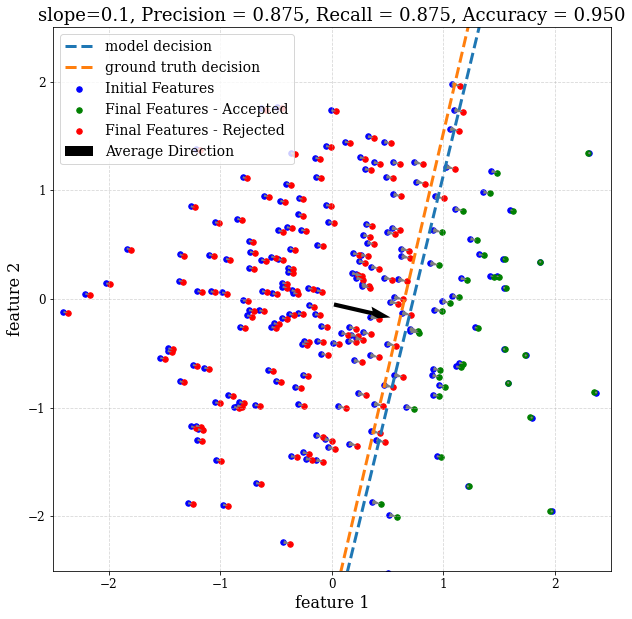

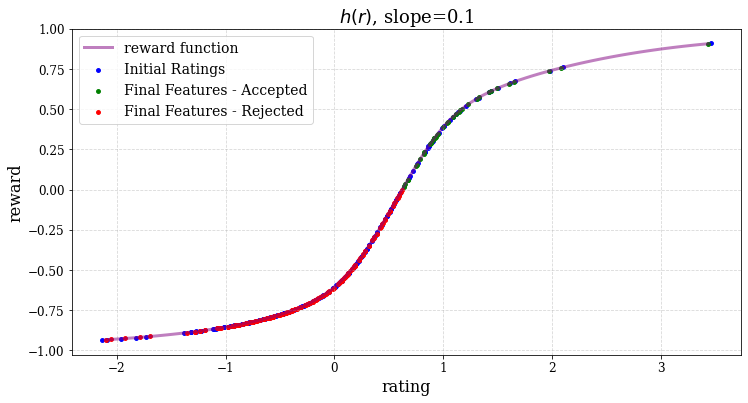

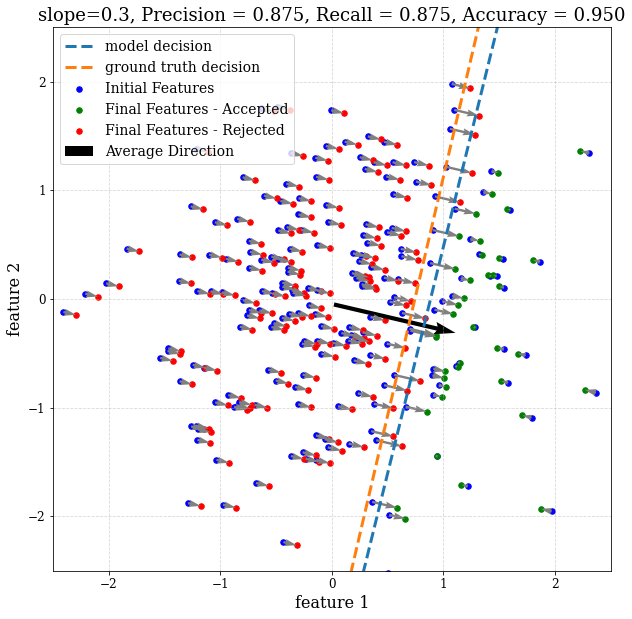

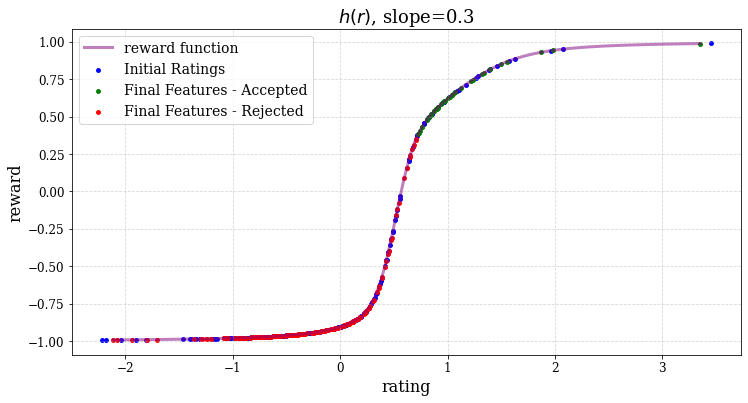

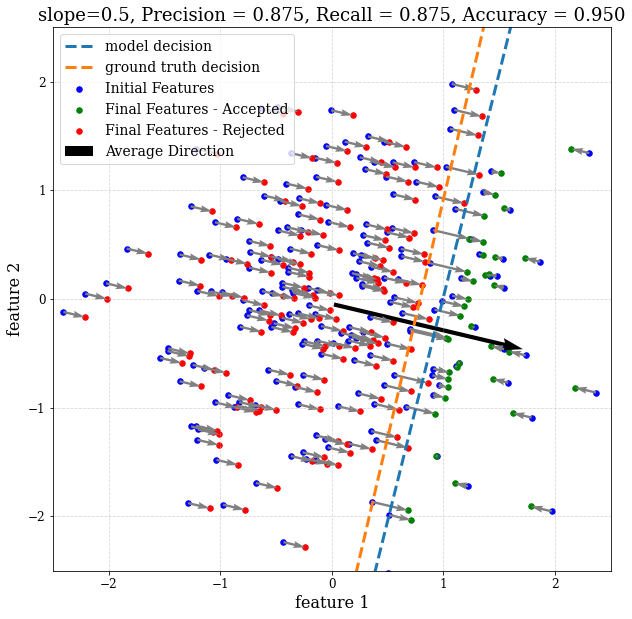

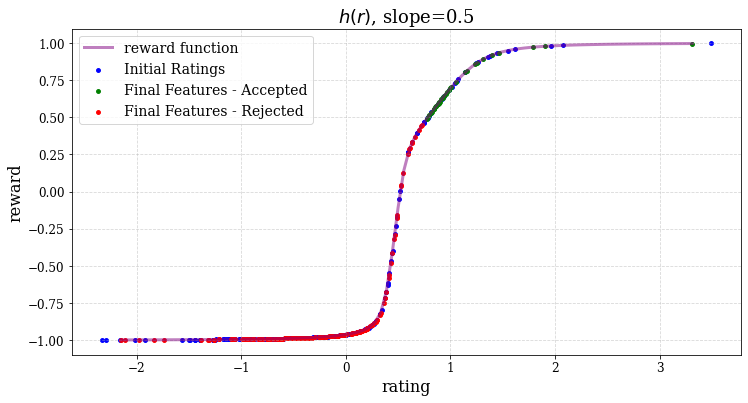

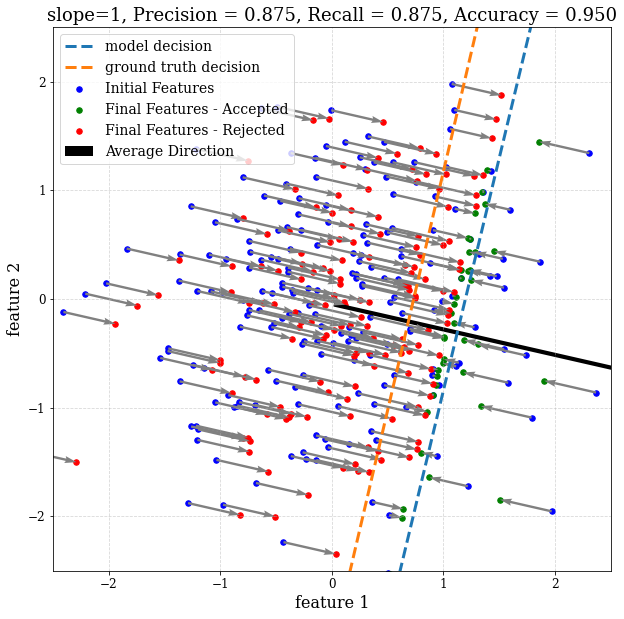

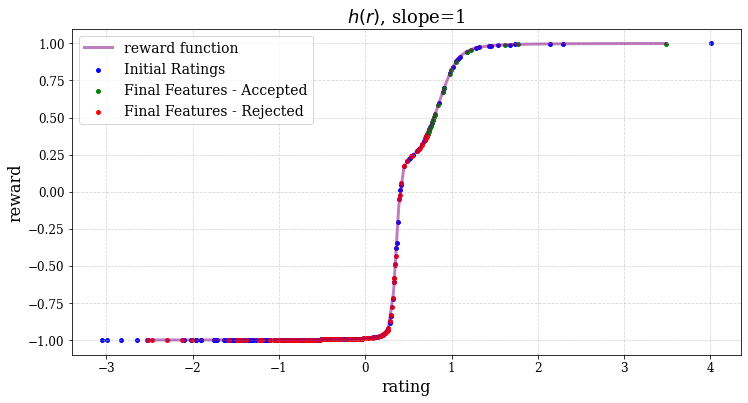

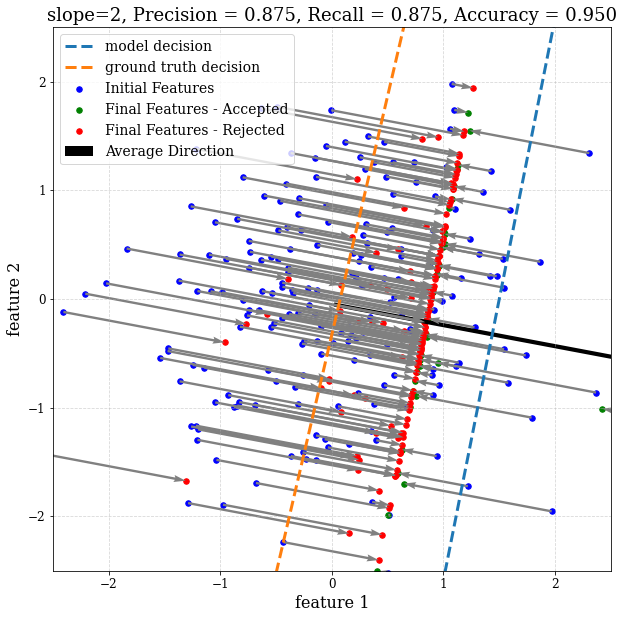

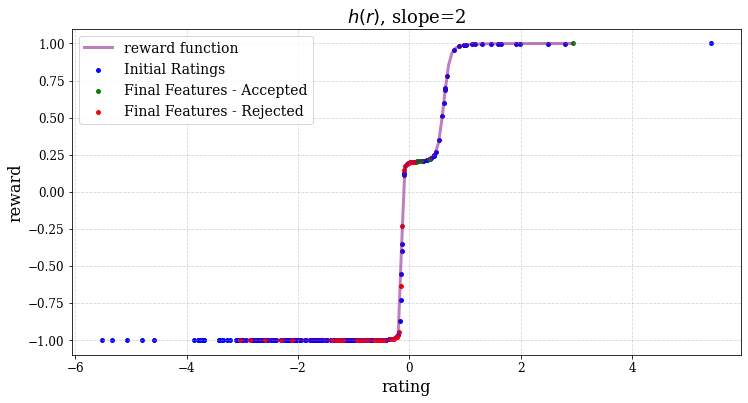

In [64]:
# defining different environments for different slopes
slope_vals = [0.1, 0.3, 0.5, 1, 2]
scale = 10

for slope_val in slope_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.2,
                'n_features' : 2, # 2 features
                'k' : 40,
                'k_tag' : 20,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch' : 5,
                'T_max' : 6}
    
    rank_env = RankingEnv(**env_params)
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*4, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/2d_slope_test_{slope_str}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=True,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'slope={slope_val}')
    plot_rating_change(rank_env, model, X_test, title=f'slope={slope_val}')
        

Need to understand why the accepted users lower their ratings. This happens when the slope is high, meaning that the gradient is very large. A possible reason can be that the CCP approximation fails for such a function, this makes sense as the Taylor approximation of a step-like function requires many coefficients.

**An idea to check this:** We can generate a plot of the points on the rating function. Plot the real $h(r)$ and on top of it a scatter of the initial ratings and new ratings with blue, green and red dots like the scatter plots above.
 

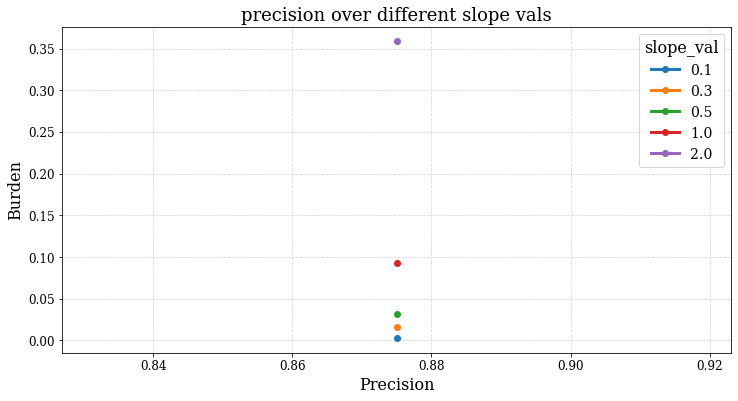

In [66]:
# seeing for which slopes we achieved better results
# defining differen environments for different slopes
slope_vals = [0.1, 0.3, 0.5, 1, 2]
train_metrics = pd.DataFrame([])
test_metrics = pd.DataFrame([])

for slope_val in slope_vals:
    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/2d_slope_test_{slope_str}/strategic"

    # reading metrics
    train_metric = pd.read_csv(path_strategic + '/train_metrics.csv')
    train_metric["slope_val"] = slope_val
    train_metrics = pd.concat([train_metrics, train_metric])

    test_metric = pd.read_csv(path_strategic + '/test_metrics.csv')
    test_metric["slope_val"] = slope_val
    test_metrics = pd.concat([test_metrics, test_metric])


# TODO: results are not good (in precision, recall and ndcg), maybe there is a problem with the model. implement naive approach (strategic data and non-strategic model) and compare
# plotting
(
    test_metrics[test_metrics['epoch num'] == 9]
    .pivot(
        index='precision',
        columns='slope_val',
        values='burden',
    )
    .plot.line(
        title='precision over different slope vals',
        xlabel='Precision',
        ylabel='Burden',
        figsize=(12,6),
        marker='o'
    )
)
plt.show()

We can see that as the slope value increases, the precision, accuracy and recall of the models decreases, while the burden increases.

It can be explained because # TODO

## Scale change 2D 

In [ ]:
# defining different environments for different slopes
# slope_vals = [0.1, 0.3, 0.5]
slope_val = 0.3
scale_vals = [1, 3, 8, 10]

for scale in scale_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.2,
                'n_features' : 2, # 2 features
                'k' : 40,
                'k_tag' : 20,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch' : 5}
    
    rank_env = RankingEnv(**env_params)
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*4, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    scale_str = str(scale).replace('.', ',')
    path_strategic = f"./tests/2d_scale_test_{scale_str}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=True,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'scale={scale}')
        

now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.90838 | err: 0.40000
batch 002 / 005 | loss: 1.80459 | err: 0.40000
batch 003 / 005 | loss: 1.66906 | err: 0.40000
batch 004 / 005 | loss: 1.49186 | err: 0.38500
batch 005 / 005 | loss: 1.33583 | err: 0.33200
model saved!
------------- epoch 001 / 010 | time: 019 sec | loss: 0.52470 | err: 0.11000
batch 001 / 005 | loss: 0.59352 | err: 0.07000
batch 002 / 005 | loss: 0.51724 | err: 0.09000
batch 003 / 005 | loss: 0.48564 | err: 0.08333


## K change experiment 
We fix $k'=\text{round}(k/2)$.

In [ ]:
# defining different environments for different slopes
# slope_vals = [0.1, 0.3, 0.5]
slope_val = 0.3
scale_vals = 5
k_vals = [10, 20, 30, 40, 50]

for k in k_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.2,
                'n_features' : 2, # 2 features
                'k' : k,
                'k_tag' : k // 2,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : scale,
                'n_batch' : 5}
    
    
    rank_env = RankingEnv(**env_params)
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*4, rating_range*slope_val)
    feature_var = X_train.var()
    rank_env.set_scale(scale / (feature_var))

    k_str = str(k).replace('.', ',')
    path_strategic = f"./tests/2d_test_k_{k_str}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=True,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'k={k},k_tag={k // 2}')
        

## k' change experiment

now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.04708 | err: 0.27000
batch 002 / 005 | loss: 0.97159 | err: 0.24000
batch 003 / 005 | loss: 0.81425 | err: 0.21333
batch 004 / 005 | loss: 0.69598 | err: 0.18750
batch 005 / 005 | loss: 0.59762 | err: 0.16200
model saved!
------------- epoch 001 / 010 | time: 019 sec | loss: 0.12150 | err: 0.06000
batch 001 / 005 | loss: 0.12116 | err: 0.06000
batch 002 / 005 | loss: 0.10410 | err: 0.05000
batch 003 / 005 | loss: 0.08897 | err: 0.06333
batch 004 / 005 | loss: 0.08240 | err: 0.05750
batch 005 / 005 | loss: 0.07864 | err: 0.06000
model saved!
------------- epoch 002 / 010 | time: 032 sec | loss: 0.07303 | err: 0.06000
batch 001 / 005 | loss: 0.09441 | err: 0.11000
batch 002 / 005 | loss: 0.09565 | err: 0.08000
batch 003 / 005 | loss: 0.10841 | err: 0.06667
batch 004 / 005 | loss: 0.11419 | err: 0.06250
batch 005 / 005 | loss: 0.11895 | err: 0.06400
model saved!
------------- epoch 003 / 010 | time: 027 sec | loss: 0.11247 | err: 0.06000
batch 001 / 005 | loss: 0

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.67225 | err: 0.40000
batch 002 / 005 | loss: 1.63725 | err: 0.40000
batch 003 / 005 | loss: 1.55233 | err: 0.39667
batch 004 / 005 | loss: 1.39362 | err: 0.37250
batch 005 / 005 | loss: 1.25412 | err: 0.33400
model saved!
------------- epoch 001 / 010 | time: 011 sec | loss: 0.53796 | err: 0.19000
batch 001 / 005 | loss: 0.57072 | err: 0.15000
batch 002 / 005 | loss: 0.51779 | err: 0.15000
batch 003 / 005 | loss: 0.50470 | err: 0.14000
batch 004 / 005 | loss: 0.45008 | err: 0.12750
batch 005 / 005 | loss: 0.40413 | err: 0.11200
model saved!
------------- epoch 002 / 010 | time: 013 sec | loss: 0.14540 | err: 0.08000
batch 001 / 005 | loss: 0.18272 | err: 0.05000
batch 002 / 005 | loss: 0.13747 | err: 0.04500
batch 003 / 005 | loss: 0.11199 | err: 0.04333
batch 004 / 005 | loss: 0.09523 | err: 0.04500
batch 005 / 005 | loss: 0.08460 | err: 0.04000
model saved!
------------- epoch 003 / 010 | time: 017 sec | loss: 0.04756 | err: 0.04000
batch 001 / 005 | loss: 0

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.67222 | err: 0.40000
batch 002 / 005 | loss: 1.63723 | err: 0.40000
batch 003 / 005 | loss: 1.55231 | err: 0.39667
batch 004 / 005 | loss: 1.39360 | err: 0.37250
batch 005 / 005 | loss: 1.25411 | err: 0.33400
model saved!
------------- epoch 001 / 010 | time: 014 sec | loss: 0.53802 | err: 0.19000
batch 001 / 005 | loss: 0.57072 | err: 0.15000
batch 002 / 005 | loss: 0.51781 | err: 0.15000
batch 003 / 005 | loss: 0.50471 | err: 0.14000
batch 004 / 005 | loss: 0.45008 | err: 0.12750
batch 005 / 005 | loss: 0.40413 | err: 0.11200
model saved!
------------- epoch 002 / 010 | time: 017 sec | loss: 0.14528 | err: 0.08000
batch 001 / 005 | loss: 0.18272 | err: 0.05000
batch 002 / 005 | loss: 0.13748 | err: 0.04500
batch 003 / 005 | loss: 0.11193 | err: 0.04333
batch 004 / 005 | loss: 0.09521 | err: 0.04500
batch 005 / 005 | loss: 0.08462 | err: 0.04000
model saved!
------------- epoch 003 / 010 | time: 021 sec | loss: 0.04772 | err: 0.04000
batch 001 / 005 | loss: 0

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.67219 | err: 0.40000
batch 002 / 005 | loss: 1.63718 | err: 0.40000
batch 003 / 005 | loss: 1.55227 | err: 0.39667
batch 004 / 005 | loss: 1.39357 | err: 0.37000
batch 005 / 005 | loss: 1.25409 | err: 0.33200
model saved!
------------- epoch 001 / 010 | time: 013 sec | loss: 0.53805 | err: 0.19000
batch 001 / 005 | loss: 0.57076 | err: 0.15000
batch 002 / 005 | loss: 0.51785 | err: 0.15000
batch 003 / 005 | loss: 0.50474 | err: 0.14000
batch 004 / 005 | loss: 0.45010 | err: 0.12750
batch 005 / 005 | loss: 0.40417 | err: 0.11200
model saved!
------------- epoch 002 / 010 | time: 018 sec | loss: 0.14531 | err: 0.08000
batch 001 / 005 | loss: 0.18279 | err: 0.05000
batch 002 / 005 | loss: 0.13752 | err: 0.04500
batch 003 / 005 | loss: 0.11190 | err: 0.04333
batch 004 / 005 | loss: 0.09519 | err: 0.04500
batch 005 / 005 | loss: 0.08464 | err: 0.04000
model saved!
------------- epoch 003 / 010 | time: 019 sec | loss: 0.04786 | err: 0.04000
batch 001 / 005 | loss: 0

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.67208 | err: 0.40000
batch 002 / 005 | loss: 1.63710 | err: 0.40000
batch 003 / 005 | loss: 1.55221 | err: 0.39667
batch 004 / 005 | loss: 1.39352 | err: 0.37000
batch 005 / 005 | loss: 1.25405 | err: 0.33200
model saved!
------------- epoch 001 / 010 | time: 013 sec | loss: 0.53808 | err: 0.19000
batch 001 / 005 | loss: 0.57081 | err: 0.15000
batch 002 / 005 | loss: 0.51790 | err: 0.15000
batch 003 / 005 | loss: 0.50479 | err: 0.14000
batch 004 / 005 | loss: 0.45015 | err: 0.12750
batch 005 / 005 | loss: 0.40421 | err: 0.11200
model saved!
------------- epoch 002 / 010 | time: 014 sec | loss: 0.14533 | err: 0.08000
batch 001 / 005 | loss: 0.18283 | err: 0.05000
batch 002 / 005 | loss: 0.13755 | err: 0.04500
batch 003 / 005 | loss: 0.11194 | err: 0.04333
batch 004 / 005 | loss: 0.09522 | err: 0.04500
batch 005 / 005 | loss: 0.08468 | err: 0.04000
model saved!
------------- epoch 003 / 010 | time: 018 sec | loss: 0.04793 | err: 0.04000
batch 001 / 005 | loss: 0

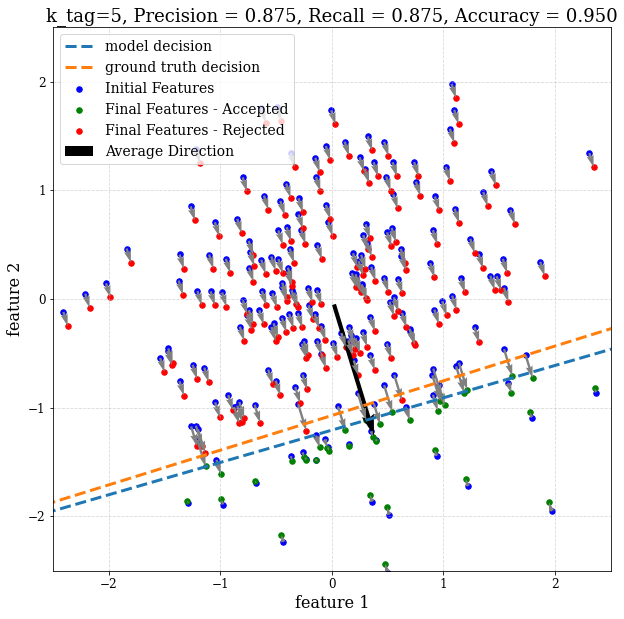

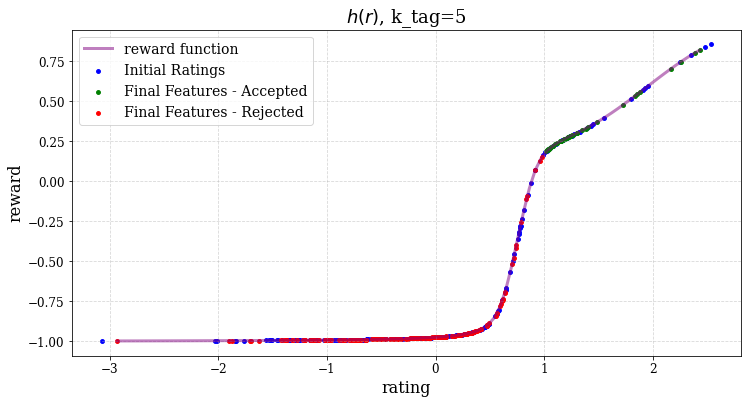

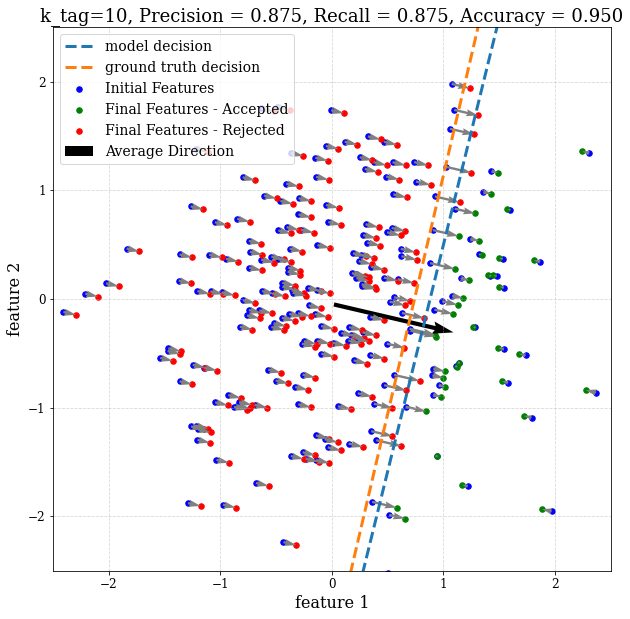

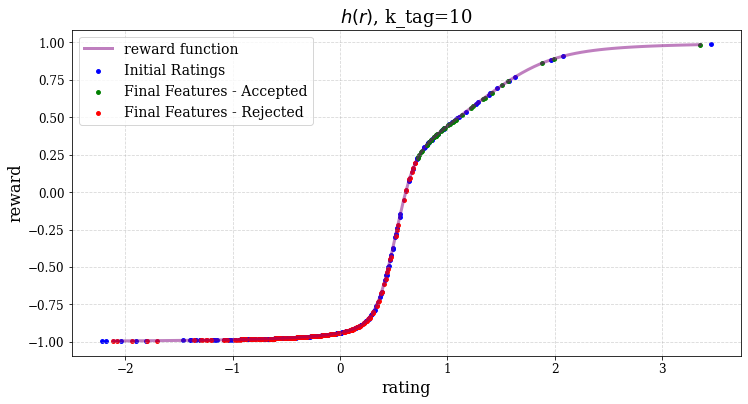

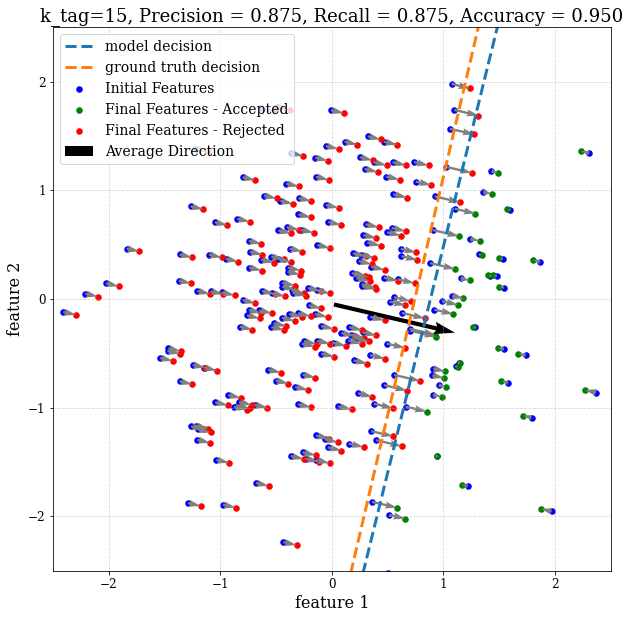

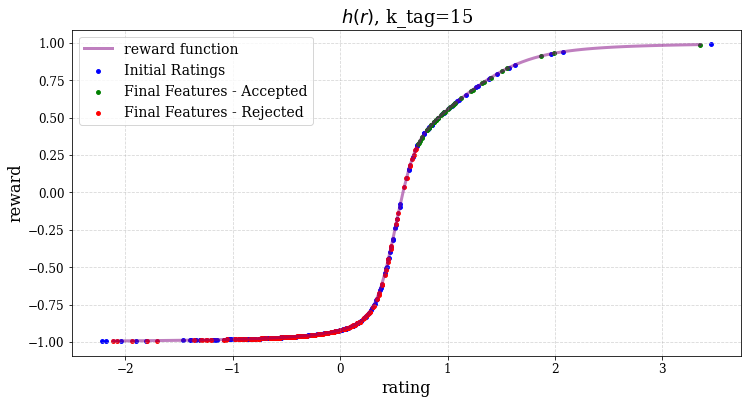

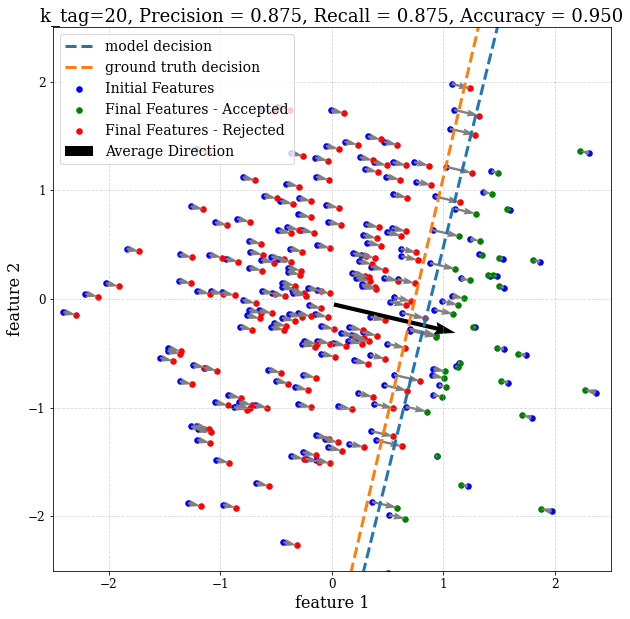

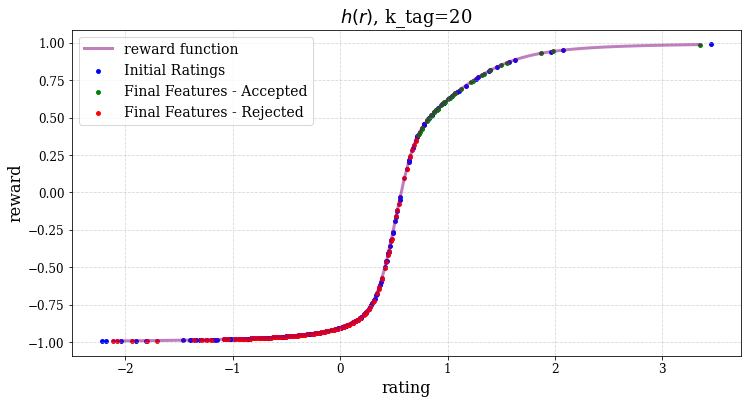

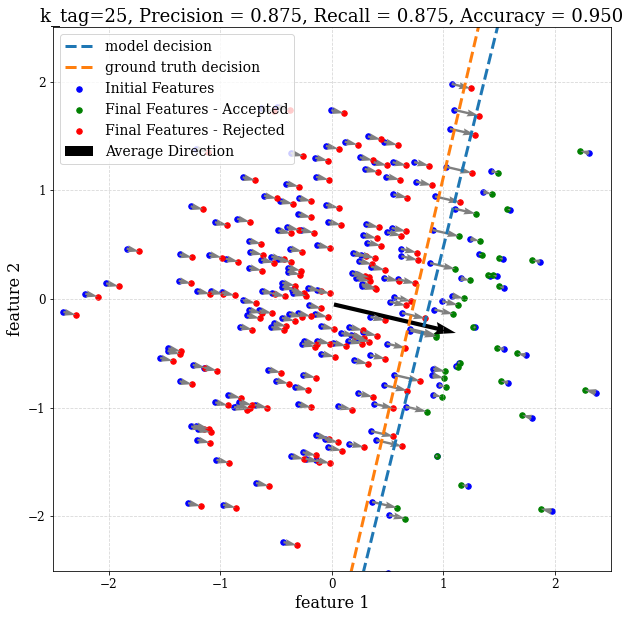

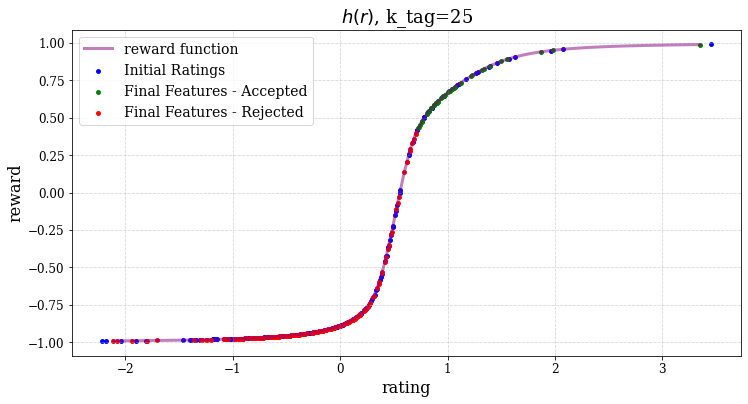

In [75]:
# defining different environments for different slopes
k_tag_vals = [5, 10, 15, 20, 25]
slope_val = 0.3
scale = 10

for k_tag in k_tag_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.2,
                'n_features' : 2, # 2 features
                'k' : 40,
                'k_tag' : k_tag,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch' : 5,
                'T_max' : 5}
    
    rank_env = RankingEnv(**env_params)
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*4, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/2d_test_k_tag_{k_tag}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=True,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'k_tag={k_tag}')
    plot_rating_change(rank_env, model, X_test, title=f'k_tag={k_tag}')
        

## Acceptance reward change experiment


now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.66934 | err: 0.40000
batch 002 / 005 | loss: 1.63403 | err: 0.40000
batch 003 / 005 | loss: 1.54996 | err: 0.39667
batch 004 / 005 | loss: 1.39158 | err: 0.37000
batch 005 / 005 | loss: 1.25256 | err: 0.33200
model saved!
------------- epoch 001 / 010 | time: 013 sec | loss: 0.53912 | err: 0.20000
batch 001 / 005 | loss: 0.57002 | err: 0.15000
batch 002 / 005 | loss: 0.51745 | err: 0.15000
batch 003 / 005 | loss: 0.50462 | err: 0.14000
batch 004 / 005 | loss: 0.45011 | err: 0.12750
batch 005 / 005 | loss: 0.40369 | err: 0.11200
model saved!
------------- epoch 002 / 010 | time: 016 sec | loss: 0.14187 | err: 0.08000
batch 001 / 005 | loss: 0.17922 | err: 0.05000
batch 002 / 005 | loss: 0.13485 | err: 0.04500
batch 003 / 005 | loss: 0.10895 | err: 0.04333
batch 004 / 005 | loss: 0.09261 | err: 0.04500
batch 005 / 005 | loss: 0.08169 | err: 0.04000
model saved!
------------- epoch 003 / 010 | time: 014 sec | loss: 0.04592 | err: 0.04000
batch 001 / 005 | loss: 0

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.66978 | err: 0.40000
batch 002 / 005 | loss: 1.63458 | err: 0.40000
batch 003 / 005 | loss: 1.55037 | err: 0.39667
batch 004 / 005 | loss: 1.39193 | err: 0.37000
batch 005 / 005 | loss: 1.25283 | err: 0.33200
model saved!
------------- epoch 001 / 010 | time: 011 sec | loss: 0.53892 | err: 0.19000
batch 001 / 005 | loss: 0.57019 | err: 0.15000
batch 002 / 005 | loss: 0.51755 | err: 0.15000
batch 003 / 005 | loss: 0.50468 | err: 0.14000
batch 004 / 005 | loss: 0.45016 | err: 0.12750
batch 005 / 005 | loss: 0.40385 | err: 0.11200
model saved!
------------- epoch 002 / 010 | time: 020 sec | loss: 0.14264 | err: 0.08000
batch 001 / 005 | loss: 0.18009 | err: 0.05000
batch 002 / 005 | loss: 0.13550 | err: 0.04500
batch 003 / 005 | loss: 0.10964 | err: 0.04333
batch 004 / 005 | loss: 0.09319 | err: 0.04500
batch 005 / 005 | loss: 0.08229 | err: 0.04000
model saved!
------------- epoch 003 / 010 | time: 014 sec | loss: 0.04582 | err: 0.04000
batch 001 / 005 | loss: 0

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.67028 | err: 0.40000
batch 002 / 005 | loss: 1.63517 | err: 0.40000
batch 003 / 005 | loss: 1.55080 | err: 0.39667
batch 004 / 005 | loss: 1.39231 | err: 0.37000
batch 005 / 005 | loss: 1.25312 | err: 0.33200
model saved!
------------- epoch 001 / 010 | time: 010 sec | loss: 0.53871 | err: 0.19000
batch 001 / 005 | loss: 0.57035 | err: 0.15000
batch 002 / 005 | loss: 0.51764 | err: 0.15000
batch 003 / 005 | loss: 0.50472 | err: 0.14000
batch 004 / 005 | loss: 0.45019 | err: 0.12750
batch 005 / 005 | loss: 0.40398 | err: 0.11200
model saved!
------------- epoch 002 / 010 | time: 012 sec | loss: 0.14337 | err: 0.08000
batch 001 / 005 | loss: 0.18086 | err: 0.05000
batch 002 / 005 | loss: 0.13611 | err: 0.04500
batch 003 / 005 | loss: 0.11030 | err: 0.04333
batch 004 / 005 | loss: 0.09376 | err: 0.04500
batch 005 / 005 | loss: 0.08290 | err: 0.04000
model saved!
------------- epoch 003 / 010 | time: 011 sec | loss: 0.04597 | err: 0.04000
batch 001 / 005 | loss: 0

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.67086 | err: 0.40000
batch 002 / 005 | loss: 1.63580 | err: 0.40000
batch 003 / 005 | loss: 1.55127 | err: 0.39667
batch 004 / 005 | loss: 1.39271 | err: 0.37000
batch 005 / 005 | loss: 1.25342 | err: 0.33200
model saved!
------------- epoch 001 / 010 | time: 012 sec | loss: 0.53850 | err: 0.19000
batch 001 / 005 | loss: 0.57049 | err: 0.15000
batch 002 / 005 | loss: 0.51772 | err: 0.15000
batch 003 / 005 | loss: 0.50475 | err: 0.14000
batch 004 / 005 | loss: 0.45018 | err: 0.12750
batch 005 / 005 | loss: 0.40407 | err: 0.11200
model saved!
------------- epoch 002 / 010 | time: 013 sec | loss: 0.14406 | err: 0.08000
batch 001 / 005 | loss: 0.18155 | err: 0.05000
batch 002 / 005 | loss: 0.13668 | err: 0.04500
batch 003 / 005 | loss: 0.11094 | err: 0.04333
batch 004 / 005 | loss: 0.09434 | err: 0.04500
batch 005 / 005 | loss: 0.08353 | err: 0.04000
model saved!
------------- epoch 003 / 010 | time: 012 sec | loss: 0.04628 | err: 0.04000
batch 001 / 005 | loss: 0

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 005 | loss: 1.67149 | err: 0.40000
batch 002 / 005 | loss: 1.63647 | err: 0.40000
batch 003 / 005 | loss: 1.55176 | err: 0.39667
batch 004 / 005 | loss: 1.39313 | err: 0.37000
batch 005 / 005 | loss: 1.25375 | err: 0.33200
model saved!
------------- epoch 001 / 010 | time: 011 sec | loss: 0.53828 | err: 0.19000
batch 001 / 005 | loss: 0.57063 | err: 0.15000
batch 002 / 005 | loss: 0.51779 | err: 0.15000
batch 003 / 005 | loss: 0.50475 | err: 0.14000
batch 004 / 005 | loss: 0.45015 | err: 0.12750
batch 005 / 005 | loss: 0.40413 | err: 0.11200
model saved!
------------- epoch 002 / 010 | time: 013 sec | loss: 0.14470 | err: 0.08000
batch 001 / 005 | loss: 0.18219 | err: 0.05000
batch 002 / 005 | loss: 0.13723 | err: 0.04500
batch 003 / 005 | loss: 0.11157 | err: 0.04333
batch 004 / 005 | loss: 0.09491 | err: 0.04500
batch 005 / 005 | loss: 0.08422 | err: 0.04000
model saved!
------------- epoch 003 / 010 | time: 019 sec | loss: 0.04720 | err: 0.04000
batch 001 / 005 | loss: 0

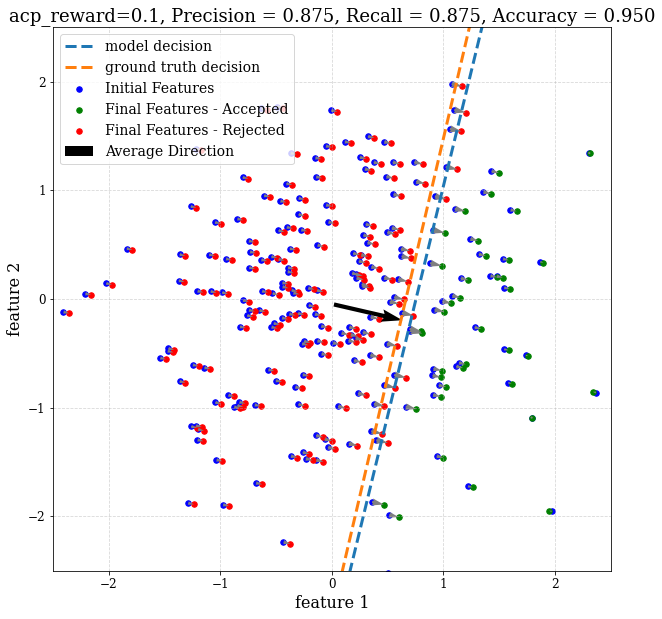

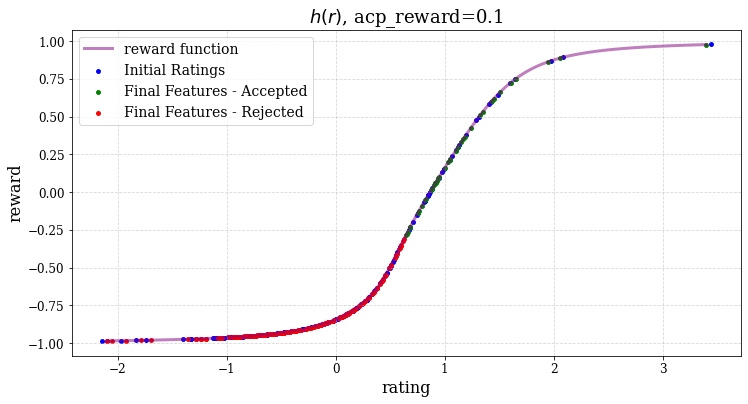

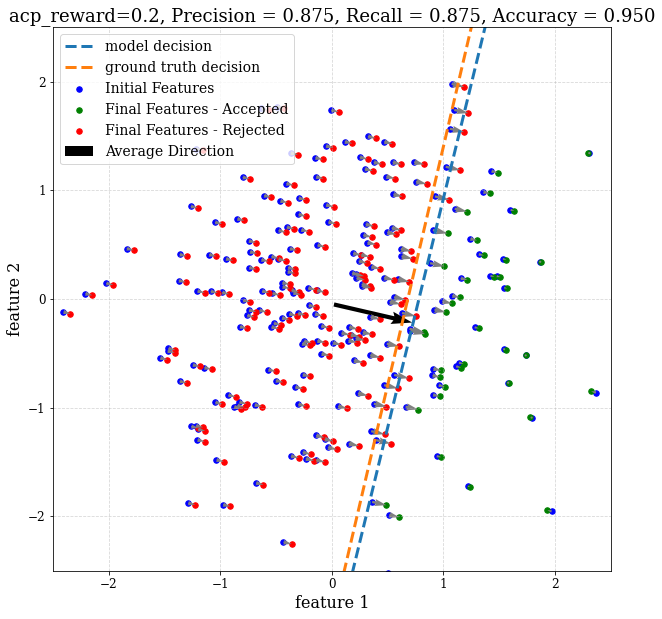

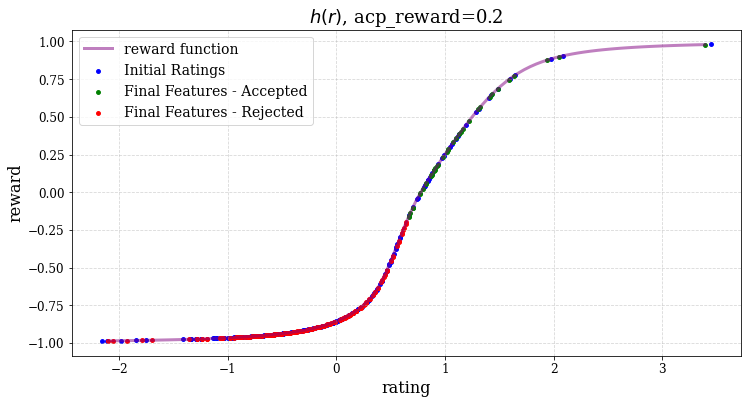

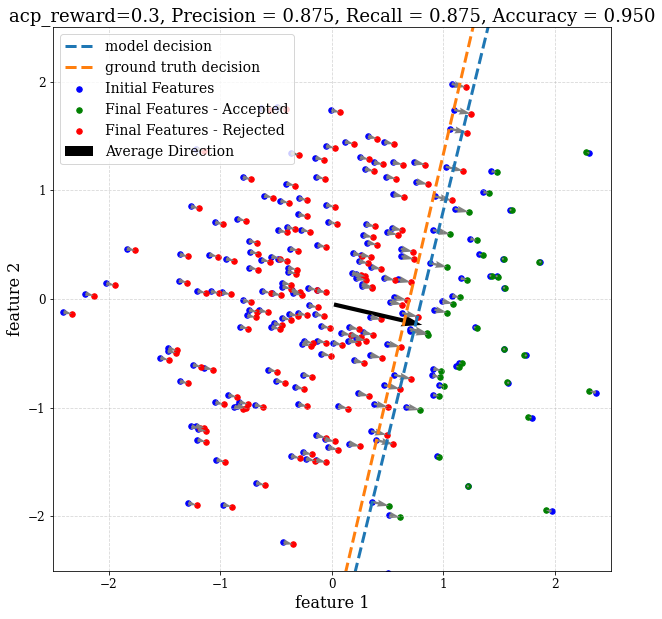

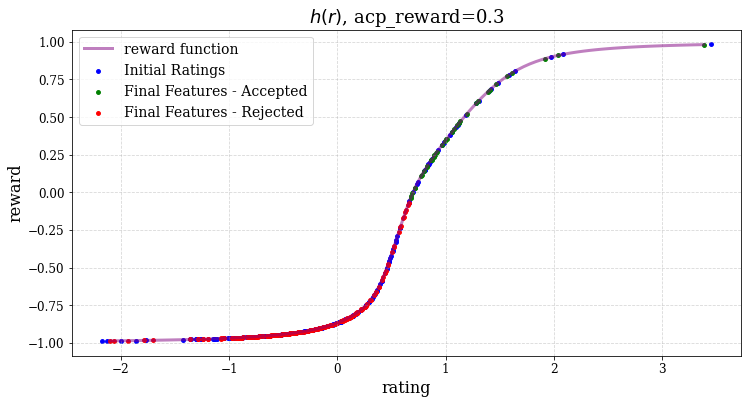

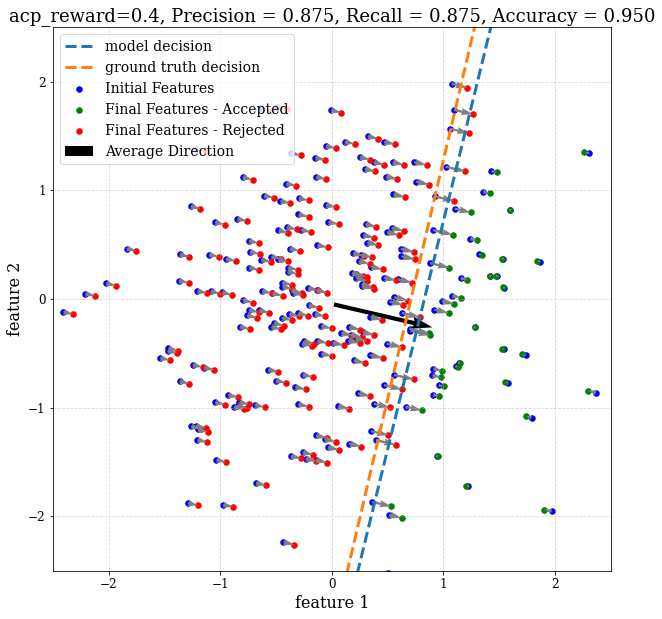

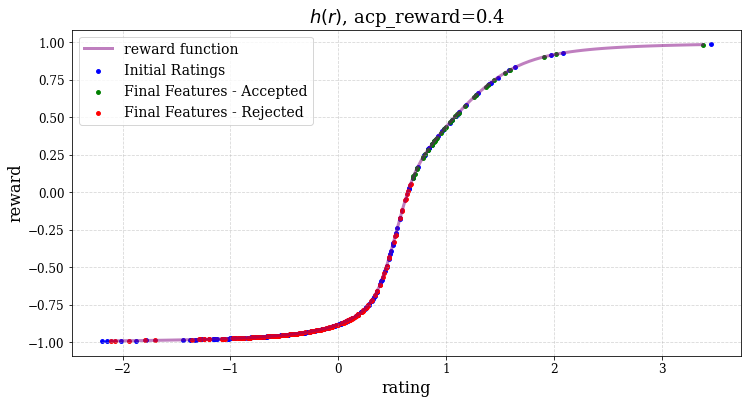

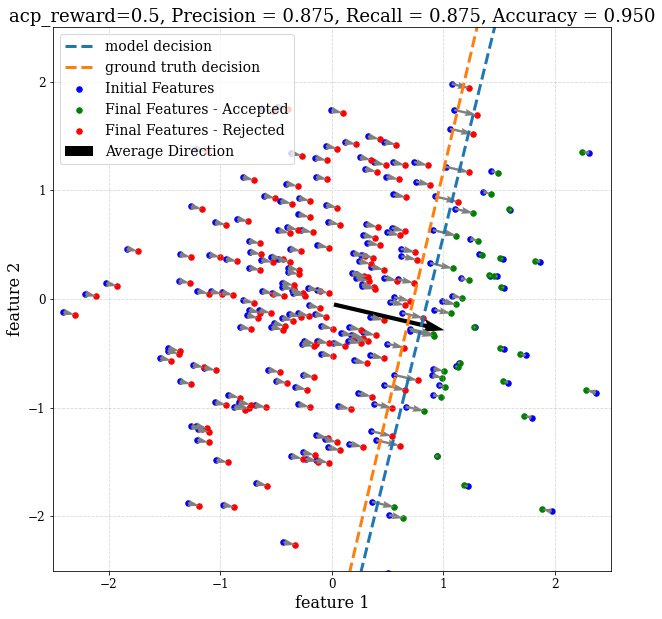

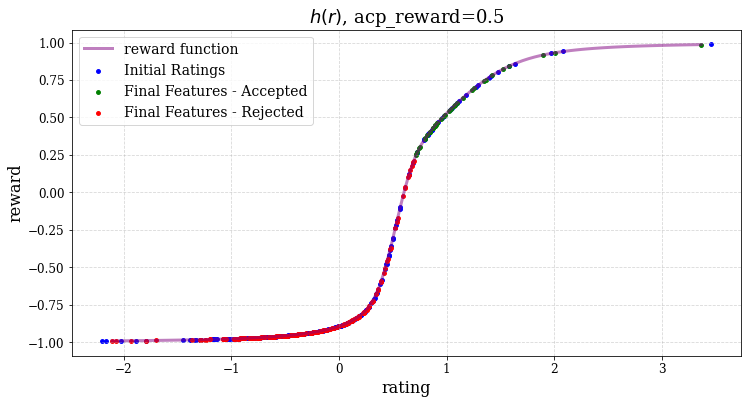

In [76]:
# defining different environments for different slopes
acp_reward_vals = [0.1, 0.2, 0.3, 0.4, 0.5]
slope_val = 0.3
scale = 10

for acp_reward in acp_reward_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.2,
                'n_features' : 2, # 2 features
                'k' : 40,
                'k_tag' : 20,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : acp_reward,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch' : 5,
                'T_max' : 5}
    
    rank_env = RankingEnv(**env_params)
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*4, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    acp_str = str(acp_reward).replace('.', ',')
    path_strategic = f"./tests/2d_test_acp_{acp_str}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=True,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'acp_reward={acp_reward}')
    plot_rating_change(rank_env, model, X_test, title=f'acp_reward={acp_reward}')
        

**Part 2:** Where users have 5 features (in 5D).

In [38]:
# defining different environments for different slopes
slope_vals = [0.1, 1, 2, 5, 10]
n_features = 5

for slope_val in slope_vals:
    # training with different slopes for 5 features
    env_params = {'noisyscale' : 0.01,
                'n_features' : n_features, # 5 features
                'k' : 40,
                'k_tag' : 20,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1}
    
    rank_env = RankingEnv(**env_params)
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset()
    X_test, R_test, y_test = rank_env.generate_dataset()

    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/slope_test_{slope_str}_{n_features}D/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=True,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)

    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')

    # over here there is no point to plot 2D scatter plots and perp lines because there are 5 features - too complicated!
    # we will only compare the results to those of the 2D users

now training strategic model


c:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 001 | loss: 1.02724 | err: 0.28000
model saved!
------------- epoch 001 / 010 | time: 002 sec | loss: 0.80824 | err: 0.24000
batch 001 / 001 | loss: 0.70119 | err: 0.24000
model saved!
------------- epoch 002 / 010 | time: 002 sec | loss: 0.54381 | err: 0.19000
batch 001 / 001 | loss: 0.46885 | err: 0.18000
model saved!
------------- epoch 003 / 010 | time: 002 sec | loss: 0.34998 | err: 0.15000
batch 001 / 001 | loss: 0.29816 | err: 0.13000
model saved!
------------- epoch 004 / 010 | time: 002 sec | loss: 0.21225 | err: 0.11000
batch 001 / 001 | loss: 0.17799 | err: 0.10000
model saved!
------------- epoch 005 / 010 | time: 002 sec | loss: 0.12333 | err: 0.08000
batch 001 / 001 | loss: 0.10341 | err: 0.07000
model saved!
------------- epoch 006 / 010 | time: 002 sec | loss: 0.07185 | err: 0.05000
batch 001 / 001 | loss: 0.06363 | err: 0.06000
model saved!
------------- epoch 007 / 010 | time: 002 sec | loss: 0.04681 | err: 0.03000
batch 001 / 001 | loss: 0.04685 | err: 0.

c:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 001 | loss: 1.27640 | err: 0.36000
model saved!
------------- epoch 001 / 010 | time: 002 sec | loss: 0.88796 | err: 0.26000
batch 001 / 001 | loss: 0.85311 | err: 0.30000
model saved!
------------- epoch 002 / 010 | time: 002 sec | loss: 0.62344 | err: 0.22000
batch 001 / 001 | loss: 0.57899 | err: 0.22000
model saved!
------------- epoch 003 / 010 | time: 002 sec | loss: 0.42820 | err: 0.17000
batch 001 / 001 | loss: 0.39621 | err: 0.15000
model saved!
------------- epoch 004 / 010 | time: 003 sec | loss: 0.29436 | err: 0.12000
batch 001 / 001 | loss: 0.28114 | err: 0.13000
model saved!
------------- epoch 005 / 010 | time: 003 sec | loss: 0.21900 | err: 0.10000
batch 001 / 001 | loss: 0.22140 | err: 0.11000
model saved!
------------- epoch 006 / 010 | time: 004 sec | loss: 0.18029 | err: 0.08000
batch 001 / 001 | loss: 0.19146 | err: 0.10000
model saved!
------------- epoch 007 / 010 | time: 003 sec | loss: 0.14985 | err: 0.07000
batch 001 / 001 | loss: 0.16426 | err: 0.

c:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 001 | loss: 1.36013 | err: 0.36000
model saved!
------------- epoch 001 / 010 | time: 004 sec | loss: 0.89589 | err: 0.26000
batch 001 / 001 | loss: 0.87548 | err: 0.30000
model saved!
------------- epoch 002 / 010 | time: 005 sec | loss: 0.61031 | err: 0.22000
batch 001 / 001 | loss: 0.57689 | err: 0.22000
model saved!
------------- epoch 003 / 010 | time: 004 sec | loss: 0.41874 | err: 0.17000
batch 001 / 001 | loss: 0.39426 | err: 0.15000
model saved!
------------- epoch 004 / 010 | time: 004 sec | loss: 0.30180 | err: 0.13000
batch 001 / 001 | loss: 0.29049 | err: 0.13000
model saved!
------------- epoch 005 / 010 | time: 005 sec | loss: 0.24217 | err: 0.09000
batch 001 / 001 | loss: 0.24310 | err: 0.12000
model saved!
------------- epoch 006 / 010 | time: 006 sec | loss: 0.20998 | err: 0.08000
batch 001 / 001 | loss: 0.22046 | err: 0.10000
model saved!
------------- epoch 007 / 010 | time: 007 sec | loss: 0.17085 | err: 0.08000
batch 001 / 001 | loss: 0.18797 | err: 0.

c:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 001 | loss: 1.56317 | err: 0.36000
model saved!
------------- epoch 001 / 010 | time: 010 sec | loss: 0.91654 | err: 0.26000
batch 001 / 001 | loss: 0.94166 | err: 0.30000
model saved!
------------- epoch 002 / 010 | time: 009 sec | loss: 0.61072 | err: 0.22000
batch 001 / 001 | loss: 0.60101 | err: 0.22000
model saved!
------------- epoch 003 / 010 | time: 013 sec | loss: 0.44063 | err: 0.17000
batch 001 / 001 | loss: 0.42174 | err: 0.15000
model saved!
------------- epoch 004 / 010 | time: 013 sec | loss: 0.35501 | err: 0.13000
batch 001 / 001 | loss: 0.33913 | err: 0.13000
model saved!
------------- epoch 005 / 010 | time: 014 sec | loss: 0.32716 | err: 0.09000
batch 001 / 001 | loss: 0.30314 | err: 0.10000
model saved!
------------- epoch 006 / 010 | time: 012 sec | loss: 0.28073 | err: 0.08000
batch 001 / 001 | loss: 0.25829 | err: 0.09000
model saved!
------------- epoch 007 / 010 | time: 016 sec | loss: 0.22971 | err: 0.08000
batch 001 / 001 | loss: 0.20236 | err: 0.

c:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 001 | loss: 1.80524 | err: 0.36000
model saved!
------------- epoch 001 / 010 | time: 014 sec | loss: 1.04843 | err: 0.26000
batch 001 / 001 | loss: 1.09649 | err: 0.30000
model saved!
------------- epoch 002 / 010 | time: 014 sec | loss: 0.70010 | err: 0.24000
batch 001 / 001 | loss: 0.67586 | err: 0.23000
model saved!
------------- epoch 003 / 010 | time: 012 sec | loss: 0.52855 | err: 0.14000
batch 001 / 001 | loss: 0.48460 | err: 0.16000
model saved!
------------- epoch 004 / 010 | time: 011 sec | loss: 0.47055 | err: 0.12000
batch 001 / 001 | loss: 0.43898 | err: 0.12000
model saved!
------------- epoch 005 / 010 | time: 014 sec | loss: 0.58159 | err: 0.09000
batch 001 / 001 | loss: 0.51107 | err: 0.11000
model saved!
------------- epoch 006 / 010 | time: 016 sec | loss: 0.62786 | err: 0.09000
batch 001 / 001 | loss: 0.57625 | err: 0.09000
model saved!
------------- epoch 007 / 010 | time: 012 sec | loss: 0.57995 | err: 0.09000
batch 001 / 001 | loss: 0.54123 | err: 0.

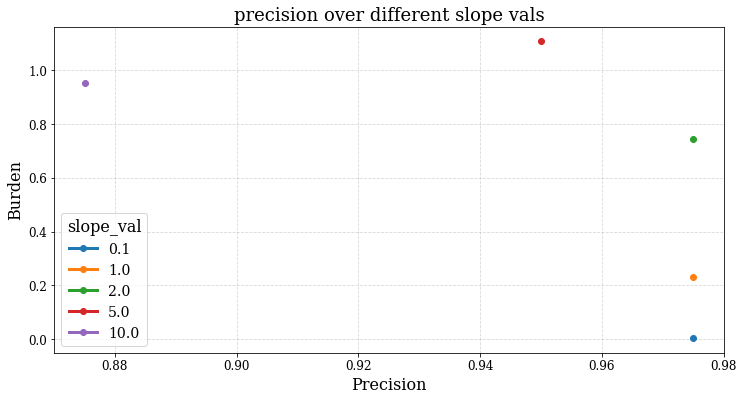

In [39]:
# seeing for which slopes we achieved better results
# defining differen environments for different slopes
slope_vals = [0.1, 1, 2, 5, 10]
train_metrics = pd.DataFrame([])
test_metrics = pd.DataFrame([])

for slope_val in slope_vals:
    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/slope_test_{slope_str}/strategic"

    # reading metrics
    train_metric = pd.read_csv(path_strategic + '/train_metrics.csv')
    train_metric["slope_val"] = slope_val
    train_metrics = pd.concat([train_metrics, train_metric])

    test_metric = pd.read_csv(path_strategic + '/test_metrics.csv')
    test_metric["slope_val"] = slope_val
    test_metrics = pd.concat([test_metrics, test_metric])


# TODO: results are not good (in precision, recall and ndcg), maybe there is a problem with the model. implement naive approach (strategic data and non-strategic model) and compare
# plotting
(
    test_metrics[test_metrics['epoch num'] == 9]
    .pivot(
        index='precision',
        columns='slope_val',
        values='burden',
    )
    .plot.line(
        title='precision over different slope vals',
        xlabel='Precision',
        ylabel='Burden',
        figsize=(12,6),
        marker='o'
    )
)
plt.show()

We can see that increasing the number of features for each user increased the complexity of the data and made the model achieve better results. 

This is likely because the model has more data to work with and based on that it reaches better approximations. #TODO

### Burden vs. Accuracy for different k values

In this experiment we will change the values of k (while keeping k in k' identical) and see how the model performs.

We can see that as k increases ... #TODO

### Burden vs. Accuracy for different k tag values

In this experiment we will change the values of k' with a fixed k value and see how the model performs.

now training strategic model


c:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 001 | loss: 1.22982 | err: 0.36000
model saved!
------------- epoch 001 / 010 | time: 002 sec | loss: 0.90786 | err: 0.26000
batch 001 / 001 | loss: 0.85520 | err: 0.30000
model saved!
------------- epoch 002 / 010 | time: 002 sec | loss: 0.62213 | err: 0.22000
batch 001 / 001 | loss: 0.57914 | err: 0.22000
model saved!
------------- epoch 003 / 010 | time: 002 sec | loss: 0.41986 | err: 0.16000
batch 001 / 001 | loss: 0.39284 | err: 0.15000
model saved!
------------- epoch 004 / 010 | time: 002 sec | loss: 0.29245 | err: 0.12000
batch 001 / 001 | loss: 0.28042 | err: 0.13000
model saved!
------------- epoch 005 / 010 | time: 002 sec | loss: 0.21590 | err: 0.09000
batch 001 / 001 | loss: 0.21545 | err: 0.11000
model saved!
------------- epoch 006 / 010 | time: 002 sec | loss: 0.16504 | err: 0.08000
batch 001 / 001 | loss: 0.17297 | err: 0.10000
model saved!
------------- epoch 007 / 010 | time: 002 sec | loss: 0.12523 | err: 0.07000
batch 001 / 001 | loss: 0.13855 | err: 0.

c:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 001 | loss: 1.22983 | err: 0.36000
model saved!
------------- epoch 001 / 010 | time: 002 sec | loss: 0.90786 | err: 0.26000
batch 001 / 001 | loss: 0.85520 | err: 0.30000
model saved!
------------- epoch 002 / 010 | time: 003 sec | loss: 0.62213 | err: 0.22000
batch 001 / 001 | loss: 0.57914 | err: 0.22000
model saved!
------------- epoch 003 / 010 | time: 003 sec | loss: 0.41987 | err: 0.16000
batch 001 / 001 | loss: 0.39284 | err: 0.15000
model saved!
------------- epoch 004 / 010 | time: 002 sec | loss: 0.29245 | err: 0.12000
batch 001 / 001 | loss: 0.28041 | err: 0.13000
model saved!
------------- epoch 005 / 010 | time: 002 sec | loss: 0.21590 | err: 0.09000
batch 001 / 001 | loss: 0.21546 | err: 0.11000
model saved!
------------- epoch 006 / 010 | time: 002 sec | loss: 0.16505 | err: 0.08000
batch 001 / 001 | loss: 0.17298 | err: 0.10000
model saved!
------------- epoch 007 / 010 | time: 002 sec | loss: 0.12525 | err: 0.07000
batch 001 / 001 | loss: 0.13856 | err: 0.

c:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 001 | loss: 1.22985 | err: 0.36000
model saved!
------------- epoch 001 / 010 | time: 002 sec | loss: 0.90785 | err: 0.26000
batch 001 / 001 | loss: 0.85520 | err: 0.30000
model saved!
------------- epoch 002 / 010 | time: 003 sec | loss: 0.62214 | err: 0.22000
batch 001 / 001 | loss: 0.57914 | err: 0.22000
model saved!
------------- epoch 003 / 010 | time: 002 sec | loss: 0.41987 | err: 0.16000
batch 001 / 001 | loss: 0.39284 | err: 0.15000
model saved!
------------- epoch 004 / 010 | time: 002 sec | loss: 0.29244 | err: 0.12000
batch 001 / 001 | loss: 0.28041 | err: 0.13000
model saved!
------------- epoch 005 / 010 | time: 003 sec | loss: 0.21589 | err: 0.09000
batch 001 / 001 | loss: 0.21546 | err: 0.11000
model saved!
------------- epoch 006 / 010 | time: 002 sec | loss: 0.16506 | err: 0.08000
batch 001 / 001 | loss: 0.17299 | err: 0.10000
model saved!
------------- epoch 007 / 010 | time: 002 sec | loss: 0.12526 | err: 0.07000
batch 001 / 001 | loss: 0.13858 | err: 0.

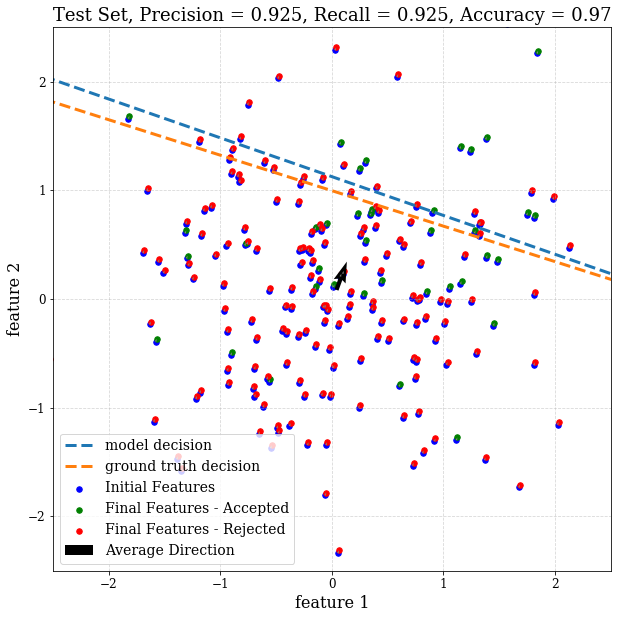

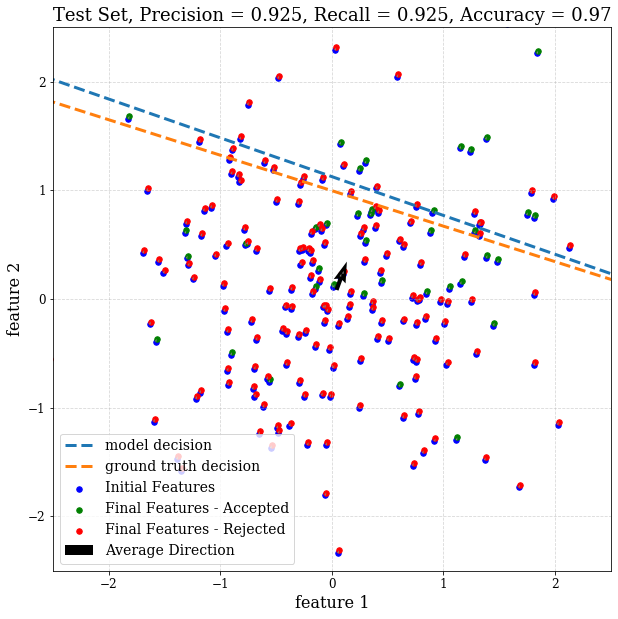

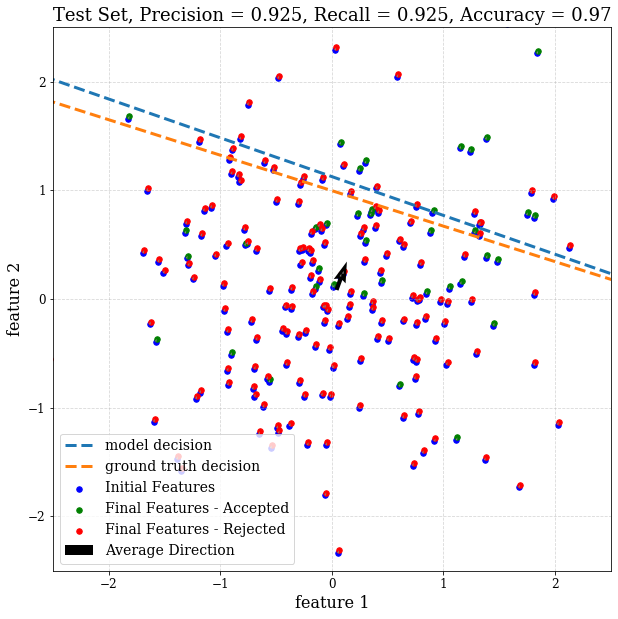

In [42]:
# defining 3 differen environments for 3 different models: low k tag, k tag, and high k tag
k_tag_vals = [40, 20, 5]


for k_tag in k_tag_vals:
    # training with different slopes
    env_params = {'noisyscale' : 0.01,
                'n_features' : 5,
                'k' : 40,
                'k_tag' : k_tag,
                'n_users': 200,
                'slope_low' : 0.1,
                'slope_high' : 0.1,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1}
    
    rank_env = RankingEnv(**env_params)
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset()
    X_test, R_test, y_test = rank_env.generate_dataset()

    path_strategic = f"./tests/k_tag_test_{k_tag}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=True,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)

    # saving baseline
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics))
        

We can see that as k' increases ... #TODO